# Generate data

In [1]:
# import cupy as np
import numpy as np
from time import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# pool = np.cuda.MemoryPool(np.cuda.malloc_managed)
# np.cuda.set_allocator(pool.malloc)


def DivisibleQ(x, b):
    if np.remainder(x, b) == 0:
        return True
    else:
        return False


def hopping_list(Lx, Ly):
    test = []        
    for i in range(Lx*Ly):
        if DivisibleQ(np.floor_divide(i, Lx), 4) == True:
            if np.remainder(i, Lx) == 0:
                test.append((i,i + Lx))
                test.append((i,i + 2*Lx-1))
                if i-Lx>0:
                    test.append((i,i-Lx))        
            else:
                test.append((i,i + Lx-1))
                test.append((i,i + Lx))
                if i-Lx>0:
                    test.append((i,i-Lx))
        if DivisibleQ(np.floor_divide(i, Lx) + 2, 4) == True:
            if np.remainder(i, Lx) == Lx-1:
                test.append((i,i+Lx))
                test.append((i,i+1))
                test.append((i,i-Lx))
            else:
                test.append((i,i+Lx+1))
                test.append((i,i+Lx))
                test.append((i,i-Lx))
    return test


    
def coordinate(j, Lx, Ly):
    x = j % Lx + 1
    ## With this notation the top left site is 0
    y = Ly - (j // Lx + 1) + 1
    if y % 2 == 1 and ((y + 1)/2) % 2 == 1:
        return (x, ((y + 1)/2) * np.sqrt(3)/2)
    if y % 2 == 1 and ((y + 1)/2) % 2 == 0:
        return (x + 1/2, ((y + 1)/2) * np.sqrt(3)/2)
    if y % 2 == 0 and (y/2) % 2 == 0:
        return (x, (y/2) * np.sqrt(3)/2 + 1/(2*np.sqrt(3)))
    if y % 2 == 0 and (y/2) % 2 == 1:
        return (x + 1/2, (y/2) * np.sqrt(3)/2 + 1/(2*np.sqrt(3)))
    
def matlab_round(x):
    if x - int(x) >= 0.5:
        return int(np.ceil(x))
    else:
        return int(x)

def hopping_matrix(Lx, Ly):
    draft_hopping = np.zeros((Lx*Ly, Lx*Ly))
    for element in hopping_list(Lx, Ly):
        draft_hopping[element] = -t
    return draft_hopping + np.transpose(draft_hopping)

################### INITIAL CONDITIONS ########################
# Revised note: Add random initial condition
# and ferromagnetic initial condition
    
## Half-half and antiferromagnetic
def initial_condition(Lx, Ly):
    lst = []
    for i in range(Lx * Ly):
        yi = Ly - (i // Lx + 1) + 1
        if yi % 2 == 0:
            lst.append(U * (nf/2))
        else:
            lst.append(U * (-nf/2))
            
    if gamma > 1e-3:
        return np.diag(np.random.choice((U * 0.001, -U * 0.001), Lx * Ly))
    else:
        return np.diag(lst)

# ## RANDOM INITIAL CONDITION ##
# def initial_condition(Lx, Ly):
# # n_up * (n_down - 1/2)
#     return np.diag(U * (np.random.rand(Lx*Ly) - nf/2))



# ## Ferromagnetic inital condition ##
# def initial_condition(Lx, Ly):
# # n_up * (n_down - 1/2)
#     lst = []
#     for i in range(Lx * Ly):
#         lst.append(U * (-nf/2))
#     return np.diag(lst)

###############################################################

def impurity_matrix(Lx, Ly):
    draft_impurity = np.zeros(Lx*Ly)
    for impurity_site in random.sample(range(Lx*Ly), matlab_round(Lx*Ly*imp)):
        draft_impurity[impurity_site] = np.random.uniform(-gamma, gamma)
    return np.diag(draft_impurity)
    
def self_consistent_solution(Lx, Ly, number_iteration=14):
    ini_hamil = hopping_matrix(Lx, Ly) + impurity_matrix(Lx, Ly)
    ini_cond = initial_condition(Lx, Ly)
    val_up, vec_up = np.linalg.eigh(ini_hamil + ini_cond)
    val_dn, vec_dn = np.linalg.eigh(ini_hamil - ini_cond) 
 
    
    def average_n_matrix(vec):
        average_n = 0
        for i in range(int((Lx*Ly+dope)/2)):
            average_n = average_n + abs(vec[:, i])**2
        average_n = U * (average_n - nf/2)
        return np.diag(average_n)
    
    # The HF loop
    hamil_up = ini_hamil + average_n_matrix(vec_dn)
    hamil_dn = ini_hamil + average_n_matrix(vec_up)    
    for i in range(number_iteration):
        print("At iteration: " + str(i))
        val_up, vec_up = np.linalg.eigh(hamil_up)
        val_dn, vec_dn = np.linalg.eigh(hamil_dn)
        hamil_up = ini_hamil + average_n_matrix(vec_dn)
        hamil_dn = ini_hamil + average_n_matrix(vec_up)
    return np.vstack((np.hstack((hamil_up, np.zeros((Lx*Ly, Lx*Ly)))),np.hstack((np.zeros((Lx*Ly, Lx*Ly)), hamil_dn))))
    # return hamil_up, hamil_dn
    



def HF_solution(Lx, Ly):
    system = self_consistent_solution(Lx, Ly)
    # val_up, vec_up = np.linalg.eigh(system[0])
    # val_dn, vec_dn = np.linalg.eigh(system[1])
    val, vec = np.linalg.eigh(system)
    return val, vec




t = 1
# U = 1
imp = 0.1
# dope = 0

# # (L, W) = (170, 144)
# Lx = 170
# Ly = 144
# nf = 1 + dope/(Lx * Ly)



# # (L, W) = (130, 112)
# Lx = 130
# Ly = 112
# nf = 1 + dope/(Lx * Ly)
# w = 7
# l_zig = 221
# l_arm = 46

# # (L, W) = (100, 64)
# Lx = 100
# Ly = 64
# nf = 1 + dope/(Lx * Ly)
# w = 4
# l_zig = 161
# l_arm = 28

# #### Test parameters
Lx = 301
Ly = 8
# nf = 1 + dope/(Lx * Ly)

####### Solve eigensystem #########

# Set up parameters
gamma = 0.06
dope = 20
U = 1
nf = 1 + dope/(Lx * Ly)

val, vec = HF_solution(Lx, Ly)

# Truncate eigensystem to reduce files' sizes
cut_off = 50
# val_up = val_up[int(Lx*Ly//2-cut_off):int(Lx*Ly//2+cut_off+1)]
# val_dn = val_dn[int(Lx*Ly//2-cut_off):int(Lx*Ly//2+cut_off+1)]
# vec_up = vec_up[:, int(Lx*Ly//2-cut_off):int(Lx*Ly//2+cut_off+1)]
# vec_dn = vec_dn[:, int(Lx*Ly//2-cut_off):int(Lx*Ly//2+cut_off+1)]


val = val[int(Lx*Ly-cut_off):int(Lx*Ly+cut_off+1)]
vec = vec[:, int(Lx*Ly-cut_off):int(Lx*Ly+cut_off+1)]

At iteration: 0
At iteration: 1
At iteration: 2
At iteration: 3
At iteration: 4
At iteration: 5
At iteration: 6
At iteration: 7
At iteration: 8
At iteration: 9
At iteration: 10
At iteration: 11
At iteration: 12
At iteration: 13


In [2]:
import numpy as np

# Lx = 120
# Ly = 8
# U = 1
# gamma = 0.1


# Normalization
vec_norm = np.zeros((Lx*Ly*2, 101))
for i in range(101):
    vec_ele = vec[:, i]
    vec_ele = vec_ele/np.linalg.norm(vec_ele)
    vec_norm[:, i] = vec_ele

vec_up = vec_norm[0:(Lx*Ly), :]
vec_dn = vec_norm[(Lx*Ly):(2*Lx*Ly), :]

val

array([-0.07826366, -0.07716509, -0.07694585, -0.07669311, -0.07668912,
       -0.07626788, -0.07590033, -0.07586545, -0.07528472, -0.074917  ,
       -0.07402523, -0.0739779 , -0.07359197, -0.07349174, -0.07313859,
       -0.07240732, -0.07185637, -0.07182149, -0.07151987, -0.07097011,
       -0.06771309, -0.06723429, -0.0665879 , -0.06653877, -0.06489019,
       -0.06318244, -0.0618499 , -0.05306705, -0.05201593, -0.04932745,
       -0.01745467, -0.01020256, -0.00931578, -0.00924816, -0.00901718,
       -0.0081213 , -0.00783204, -0.00411033, -0.00239008, -0.00023854,
        0.00117679,  0.00303381,  0.00522354,  0.0085589 ,  0.00899771,
        0.00936488,  0.00938077,  0.01098486,  0.01171935,  0.01394132,
        0.01470525,  0.01704683,  0.02561359,  0.02576848,  0.02767886,
        0.02945295,  0.03844003,  0.04788311,  0.04856265,  0.0495636 ,
        0.04960904,  0.05183146,  0.05212279,  0.05244813,  0.0548041 ,
        0.05570478,  0.06370181,  0.06397897,  0.06768747,  0.06

In [3]:
########## Replace norm by sum
def prob_density(vector_solution, order, Lx, Ly):
    density = np.power(vector_solution[:, order], 2)
    density = density/np.sum(density)
    return np.matrix.flatten(density).tolist()


listA = []
listB = []
list_overlap = []
# vec = np.matrix(vec)
dope = 0

for i in range(Lx * Ly):
    yi = Ly - (i // Lx + 1) + 1
    if yi % 2 == 0:
        listA.append(i)
    else:
        listB.append(i)

for i in range(Lx * Ly):
    yi = Ly - (i // Lx + 1) + 1
    if Ly/2 -1 <= yi <= Ly/2:
        list_overlap.append(i)

        
        
####### Compute charge on sites A and B here
print("=============x=============")

for i in range(10, 90):
    ORDER_up = i
    ORDER_dn = i


    density_up = prob_density(vec_up, ORDER_up, Lx, Ly)
    qa_up = np.sum(np.take(prob_density(vec_up, ORDER_up, Lx, Ly), listA))
    energy_up = val[ORDER_up]

    density_dn = prob_density(vec_dn, ORDER_dn, Lx, Ly)
    qa_dn = np.sum(np.take(prob_density(vec_dn, ORDER_dn, Lx, Ly), listA))
    energy_dn = val[ORDER_dn]

    print("Energy with order " + str(ORDER_up) + ": ", energy_up)
    print(qa_up)
    print(qa_dn)

ORDER_up = 38
ORDER_dn = ORDER_up


density_up = prob_density(vec_up, ORDER_up, Lx, Ly)
qa_up = np.sum(np.take(prob_density(vec_up, ORDER_up, Lx, Ly), listA))
energy_up = val[ORDER_up]

density_dn = prob_density(vec_dn, ORDER_dn, Lx, Ly)
qa_dn = np.sum(np.take(prob_density(vec_dn, ORDER_dn, Lx, Ly), listA))

print("Energy spin up with order " + str(ORDER_up) + ": ", energy_up)
print(qa_up)


print("Energy spin dn with order " + str(ORDER_dn) + ": ", energy_dn)
print(qa_dn)



=============x=============
Energy with order 10:  -0.07402523345506626
0.4973374190820873
nan
Energy with order 11:  -0.07397790176965173
nan
0.43820906155495293
Energy with order 12:  -0.07359197482465633
nan
0.30330917598382123
Energy with order 13:  -0.07349173762965693
0.6203447895480534
nan
Energy with order 14:  -0.07313859117894247
nan
0.45404331222905825
Energy with order 15:  -0.07240731808610956
0.7754353445596706
nan
Energy with order 16:  -0.07185637172778186
0.5119497098981841
nan
Energy with order 17:  -0.07182149014916452
nan
0.12245567347924738
Energy with order 18:  -0.07151987213686306
0.11920835500604227
nan
Energy with order 19:  -0.07097010830105496
nan
0.6831884112528066
Energy with order 20:  -0.06771308526497778
nan
0.45963248182060223
Energy with order 21:  -0.06723428935847947
0.6903241614756591
nan
Energy with order 22:  -0.06658789546776134
0.520456237514897
nan
Energy with order 23:  -0.06653877464533531
nan
0.6856482837274783
Energy with order 24:  -0.064

/var/folders/8c/yvgv5fnx2nb77hcl4bw6dtzr0000gn/T/ipykernel_10672/133886839.py:4: RuntimeWarning: invalid value encountered in divide
  density = density/np.sum(density)


## Pick a nice one to plot

NameError: name 'density_up' is not defined

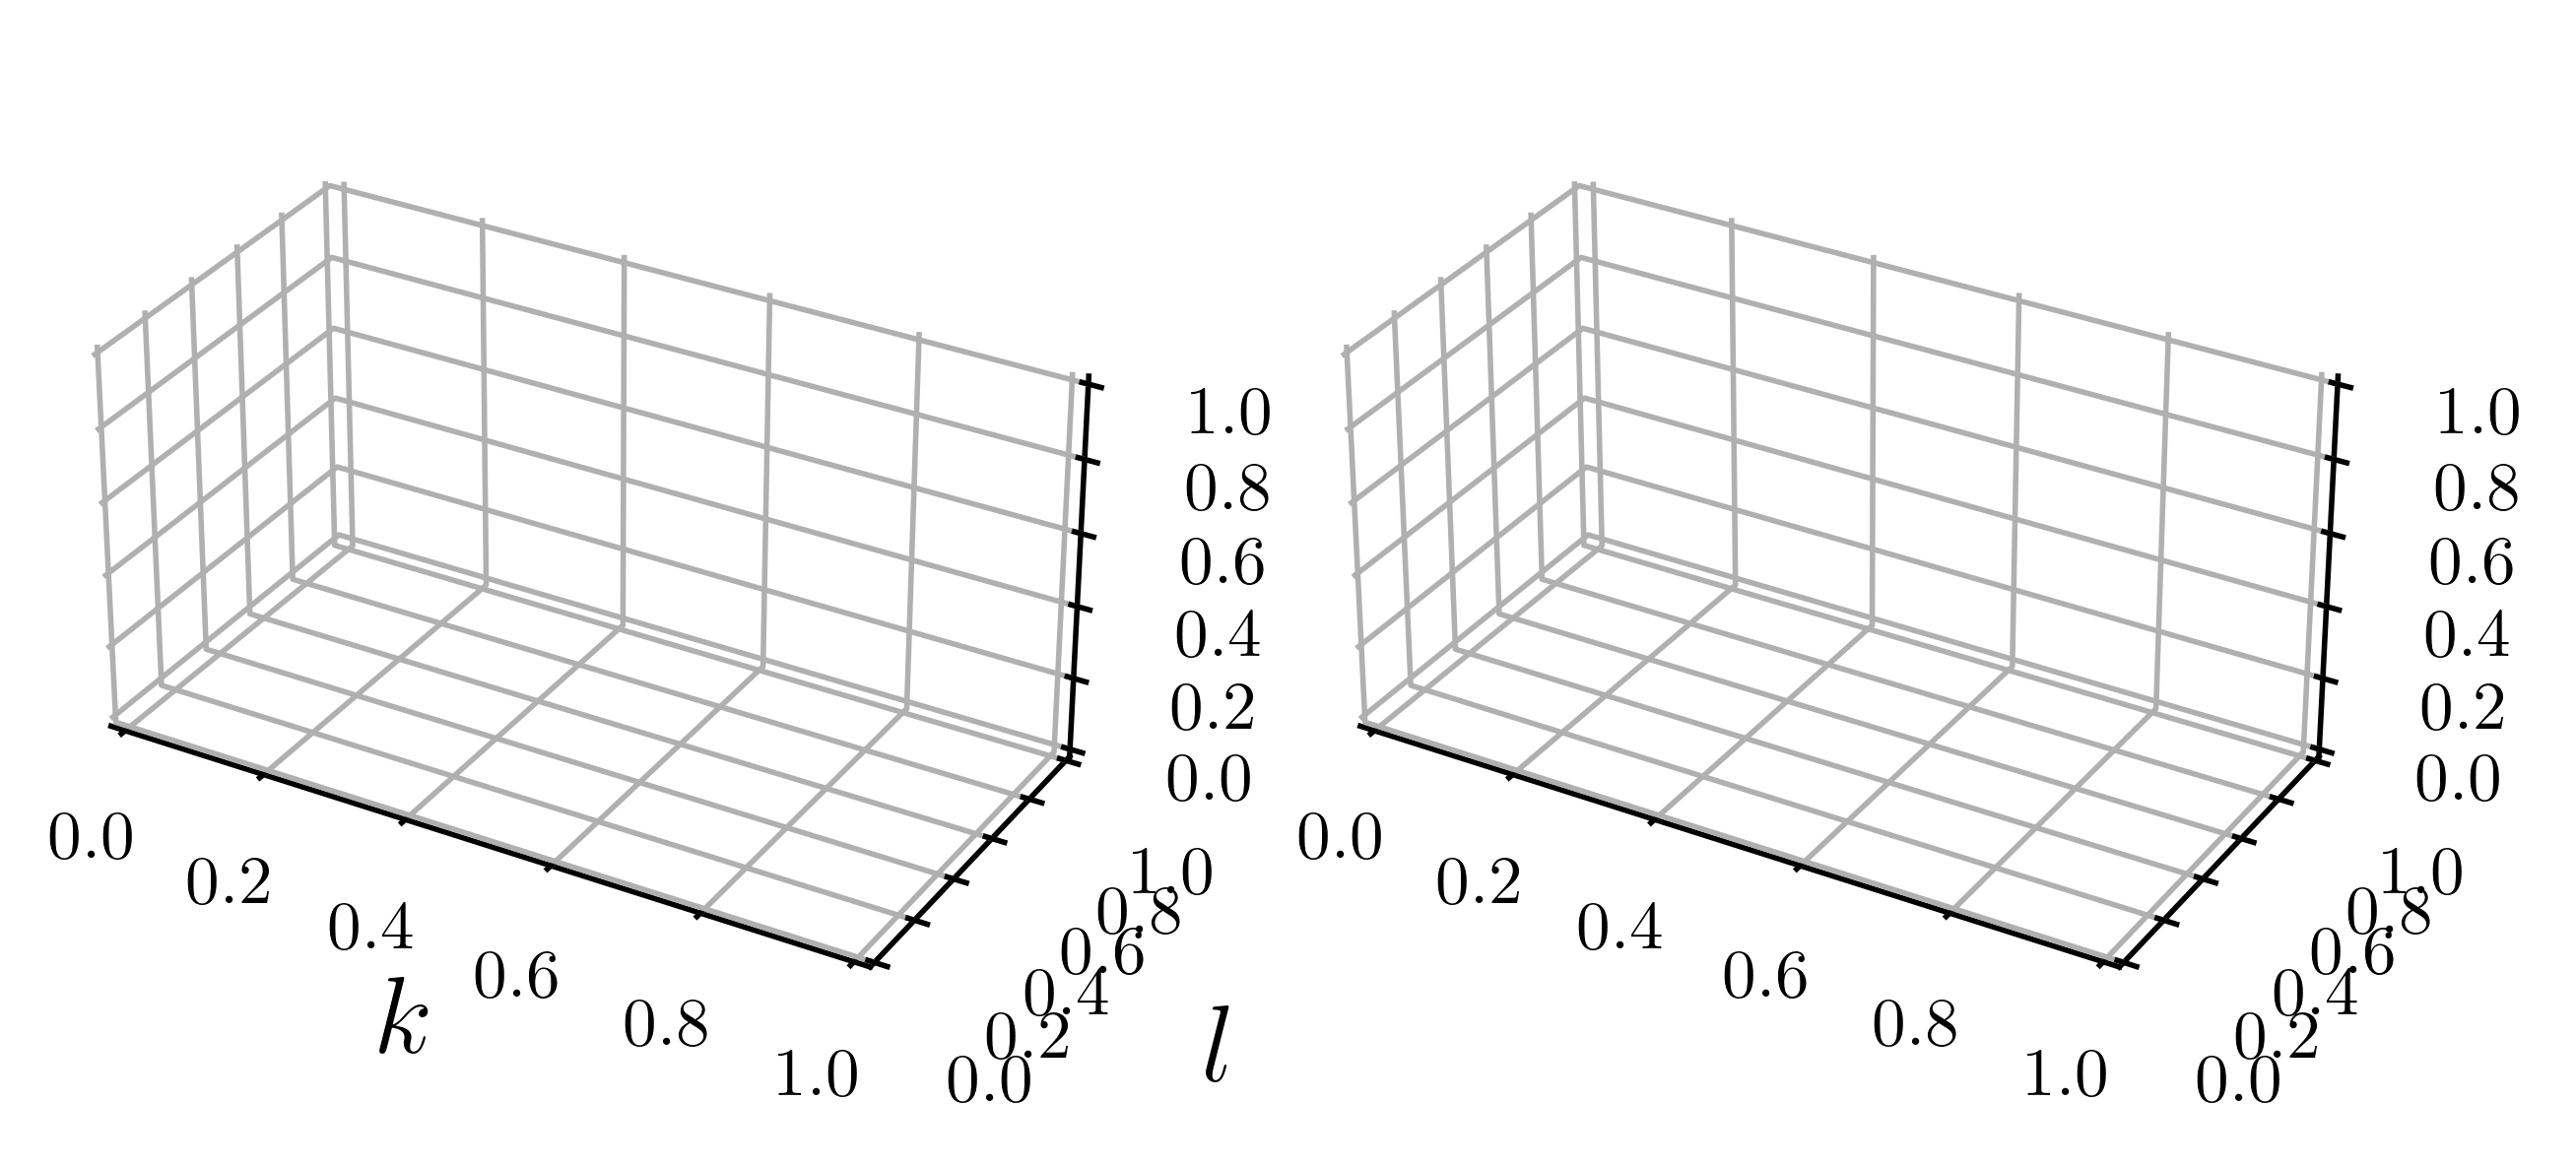

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

plt.rcParams.update({'text.usetex': True})


fig = plt.figure(dpi=500)
ax = fig.add_subplot(1,2,1, projection="3d")
ax1 = fig.add_subplot(1,2,2, projection="3d")


listA = []
listB = []
list_overlap = []


for i in range(Lx * Ly):
    yi = Ly - (i // Lx + 1) + 1
    if yi % 2 == 0:
        listA.append(i)
    else:
        listB.append(i)

for i in range(Lx * Ly):
    yi = Ly - (i // Lx + 1) + 1
    if Ly/2 -1 <= yi <= Ly/2:
        list_overlap.append(i)




# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=10, hspace=None)


ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlabel("$k$", fontsize=16)
ax.set_ylabel("$l$", fontsize=16)
ax.zaxis.set_rotate_label(False) 
# ax.set_zlabel("$| \psi |^2$", fontsize=16, rotation=0)
ax.set_box_aspect((2,1,1))
ax.grid([1])


ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax1.set_xlabel("$k$", fontsize=16)
# ax1.set_ylabel("$l$", fontsize=16)
ax1.zaxis.set_rotate_label(False) 
# ax1.set_zlabel("$| \psi |^2$", fontsize=16, rotation=0)
ax1.set_box_aspect((2,1,1))




colors = [
    '#0504aa',  # blue royal
    '#01ff07',  # green light
]



# Make data.
X = np.arange(Lx)
Y = np.arange(Ly)
X, Y = np.meshgrid(X, Y)


    
### For fractional charges, we plot A sites and B sites separately
### where A and B sites differ in Ly


prob_A_up = []
prob_B_up = []
for site_index, element in enumerate(density_up):
    yi = Ly - (site_index // Lx + 1) + 1
    if yi % 2 == 0:
        prob_A_up.append(0)
        prob_B_up.append(element)
    else:
        prob_A_up.append(element)
        prob_B_up.append(0)

prob_A_dn = []
prob_B_dn = []
for site_index, element in enumerate(density_dn):
    yi = Ly - (site_index // Lx + 1) + 1
    if yi % 2 == 0:
        prob_A_dn.append(0)
        prob_B_dn.append(element)
    else:
        prob_A_dn.append(element)
        prob_B_dn.append(0) 




col1 = np.full(np.reshape(prob_A_dn, (Ly, Lx)).shape, 'blue')
col1[Ly-1, :] = np.full(Lx, 'none')
col2 = np.full(np.reshape(prob_B_dn, (Ly, Lx)).shape, 'lime')
col2[Ly-1, :] = np.full(Lx, 'none')

ax.plot_surface(np.append(X, X, axis=0),
                np.append(Y, Y, axis=0),
                np.append(np.reshape(prob_A_up, (Ly, Lx)), 
                          np.reshape(prob_B_up, (Ly, Lx)), axis=0),
                  facecolors= np.append(col1, col2, axis=0),
                 antialiased=True, edgecolors='k', linewidth=0, rstride=1, cstride=1,
                zorder=1, shade=False)



col1 = np.full(np.reshape(prob_A_up, (Ly, Lx)).shape, 'blue')
col1[Ly-1, :] = np.full(Lx, 'none')
col2 = np.full(np.reshape(prob_B_up, (Ly, Lx)).shape, 'lime')
col2[Ly-1, :] = np.full(Lx, 'none')

ax1.plot_surface(np.append(X, X, axis=0),
                np.append(Y, Y, axis=0),
                np.append(np.reshape(prob_A_dn, (Ly, Lx)), 
                          np.reshape(prob_B_dn, (Ly, Lx)), axis=0),
                  facecolors= np.append(col1, col2, axis=0),
                 antialiased=True, edgecolors='w', linewidth=0, rstride=1, cstride=1,
                zorder=1, shade=False)



ax.set_xticks(np.arange(0, Lx+1, Lx//5))
ax1.set_xticks(np.arange(0, Lx+1, Lx//2))

ax.set_yticks(np.arange(0, Ly+1, Ly//4))
ax1.set_yticks(np.arange(0, Ly+1, Ly//2))

ax1.set_zticks([0.04, 0.08])

ax.view_init(elev=20., azim=-50)
ax1.view_init(elev=20., azim=-50)

ax1.tick_params(axis='both', which='major', labelsize=16)

ax.set_title(r"$E = %1.5f, q_{A, \uparrow} = %1.5f $" 
             % tuple((energy_up, qa_up)))

ax1.set_title(r"$E = %1.5f, q_{A, \downarrow} = %1.5f $" 
             % tuple((energy_dn, qa_dn)))

# ax.grid(False)
# ax1.grid(False)


# fig.tight_layout(rect=[0.1, 0.2, 1, 1.1])
fig.tight_layout(w_pad=3)



# plt.savefig("prob_density_dope5_U5_G01.png")

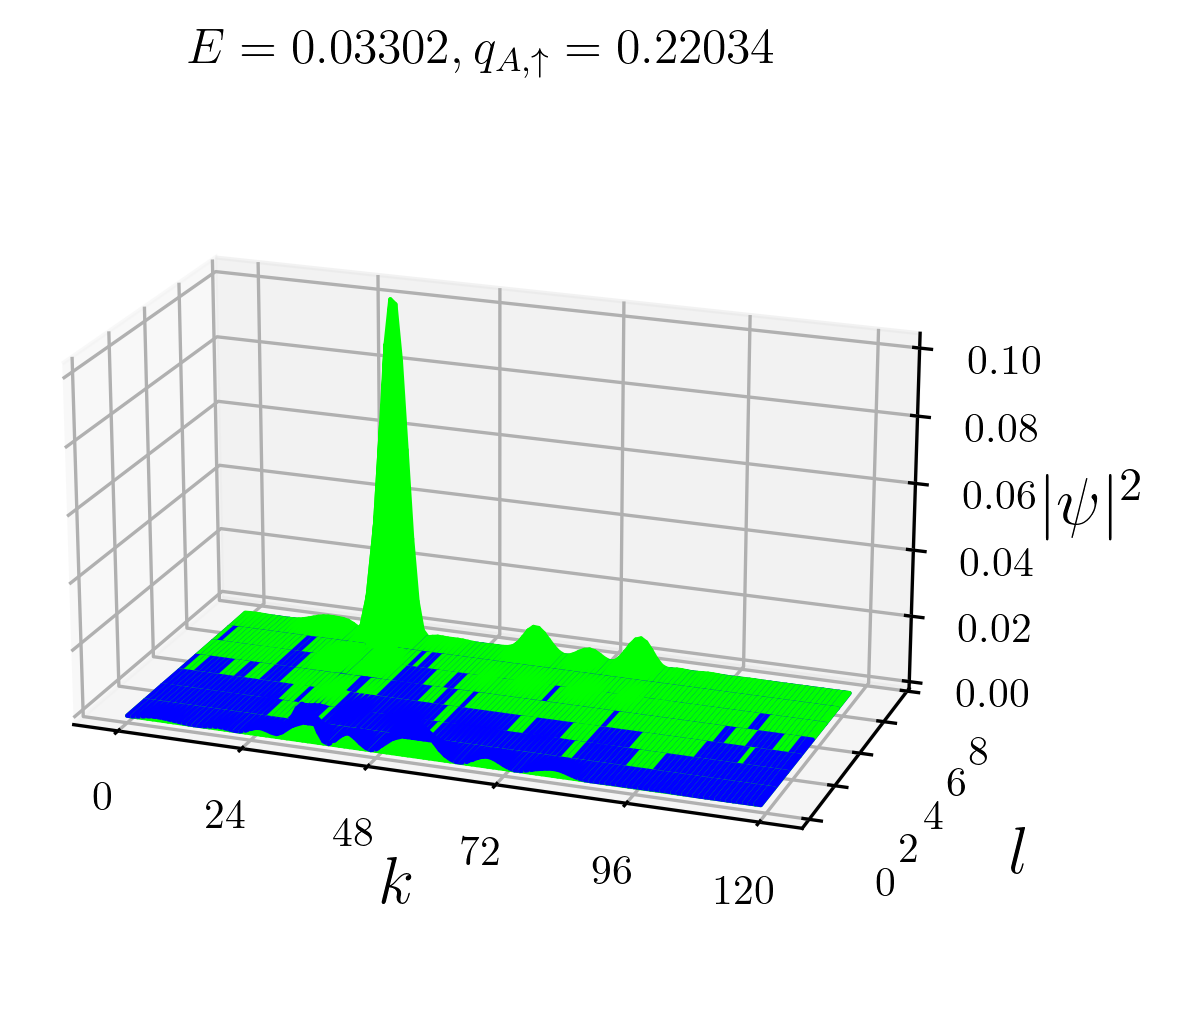

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

plt.rcParams.update({'text.usetex': True})

fig = plt.figure(dpi=300)
ax = fig.add_subplot(1,1,1, projection="3d")


listA = []
listB = []
list_overlap = []


for i in range(Lx * Ly):
    yi = Ly - (i // Lx + 1) + 1
    if yi % 2 == 0:
        listA.append(i)
    else:
        listB.append(i)

for i in range(Lx * Ly):
    yi = Ly - (i // Lx + 1) + 1
    if Ly/2 -1 <= yi <= Ly/2:
        list_overlap.append(i)




plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)


# ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlabel("$k$", fontsize=16)
ax.set_ylabel("$l$", fontsize=16)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel("$| \psi |^2$", fontsize=16, rotation=0)
ax.set_box_aspect((2,1,1))
ax.grid([1])







colors = [
    '#0504aa',  # blue royal
    '#01ff07',  # green light
]



# Make data.
X = np.arange(Lx)
Y = np.arange(Ly)
X, Y = np.meshgrid(X, Y)


    
### For fractional charges, we plot A sites and B sites separately
### where A and B sites differ in Ly


prob_A_up = []
prob_B_up = []
for site_index, element in enumerate(density_up):
    yi = Ly - (site_index // Lx + 1) + 1
    if yi % 2 == 0:
        prob_A_up.append(0)
        prob_B_up.append(element)
    else:
        prob_A_up.append(element)
        prob_B_up.append(0)



col1 = np.full(np.reshape(prob_A_up, (Ly, Lx)).shape, 'lime')
col1[Ly-1, :] = np.full(Lx, 'none')
col2 = np.full(np.reshape(prob_B_up, (Ly, Lx)).shape, 'blue')
col2[Ly-1, :] = np.full(Lx, 'none')

ax.plot_surface(np.append(X, X, axis=0),
                np.append(Y, Y, axis=0),
                np.append(np.reshape(prob_A_up, (Ly, Lx)), 
                          np.reshape(prob_B_up, (Ly, Lx)), axis=0),
                  facecolors= np.append(col1, col2, axis=0),
                 antialiased=True, edgecolors='k', linewidth=1, rstride=1, cstride=1,
                zorder=1, shade=False)





ax.set_xticks(np.arange(0, Lx+1, Lx//5))

ax.set_yticks(np.arange(0, Ly+1, Ly//4))


ax.view_init(elev=20., azim=-70)


ax.set_title(r"$E = %1.5f, q_{A, \uparrow} = %1.5f $" 
             % tuple((energy_up, qa_up)))



# ax.grid(False)


# fig.tight_layout(rect=[0.1, 0.2, 1, 1.01])


# plt.savefig("prob_density_dope5_U5_G01.png")

plt.show()

## Plot all states

/var/folders/8c/yvgv5fnx2nb77hcl4bw6dtzr0000gn/T/ipykernel_10672/133886839.py:4: RuntimeWarning: invalid value encountered in divide
  density = density/np.sum(density)
/var/folders/8c/yvgv5fnx2nb77hcl4bw6dtzr0000gn/T/ipykernel_10672/2600325532.py:76: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(np.append(X, X, axis=0),
/var/folders/8c/yvgv5fnx2nb77hcl4bw6dtzr0000gn/T/ipykernel_10672/2600325532.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(dpi=100)


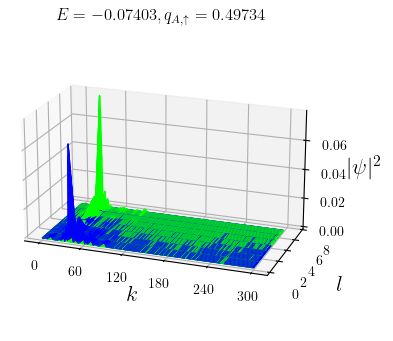

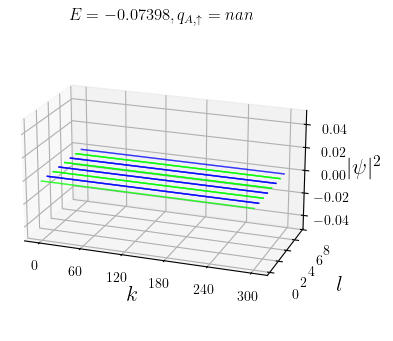

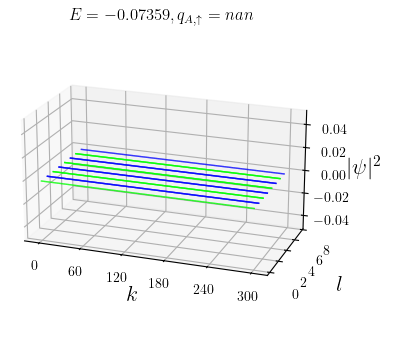

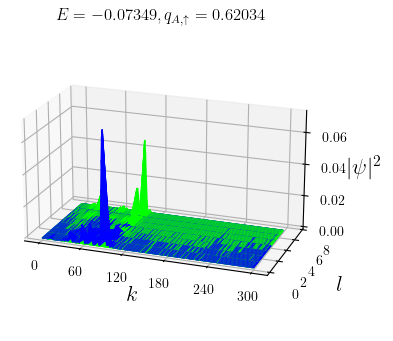

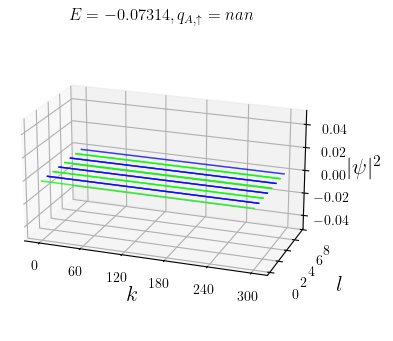

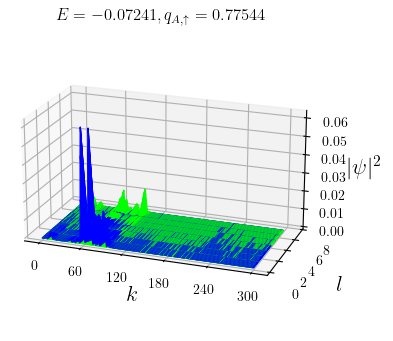

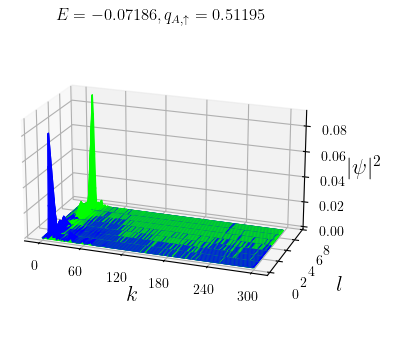

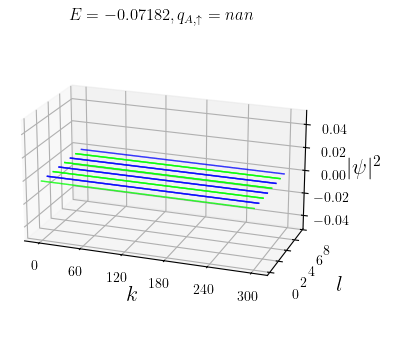

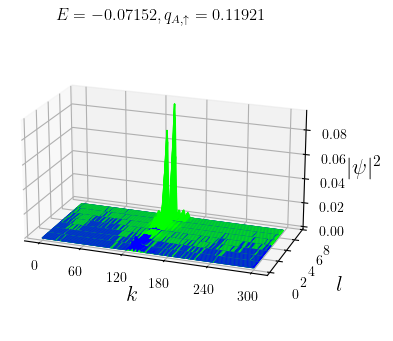

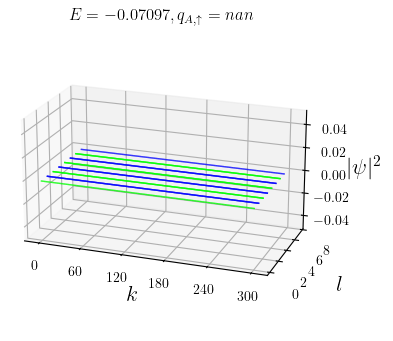

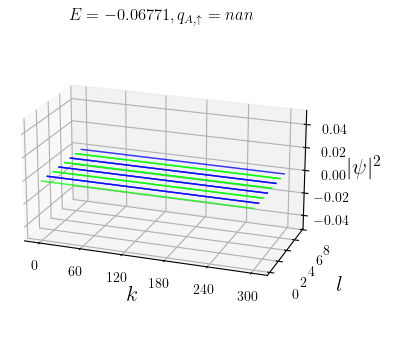

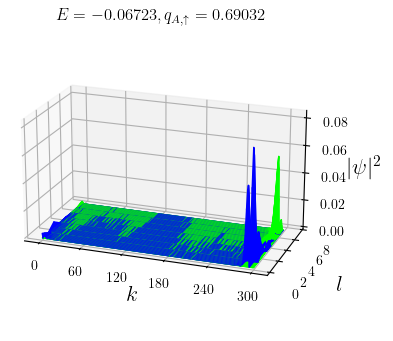

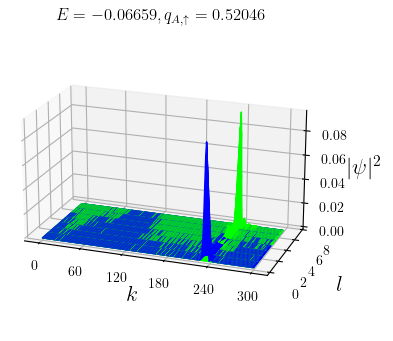

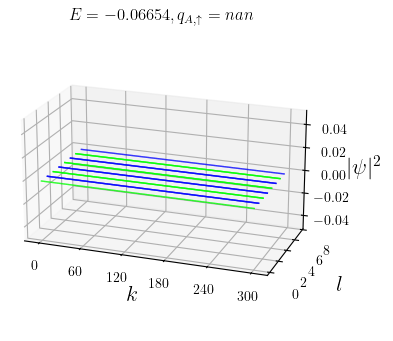

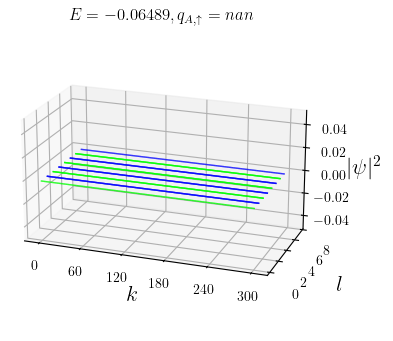

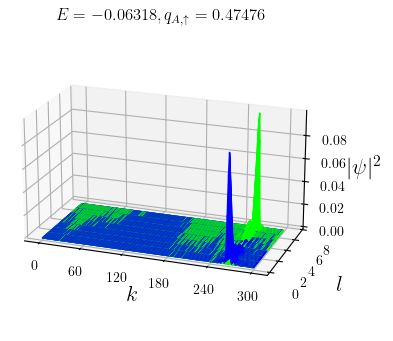

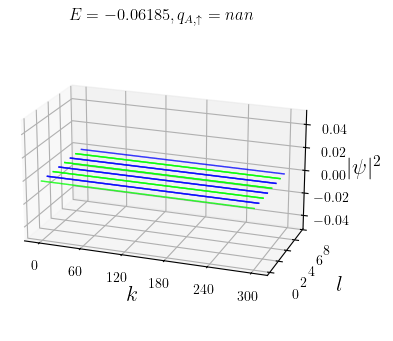

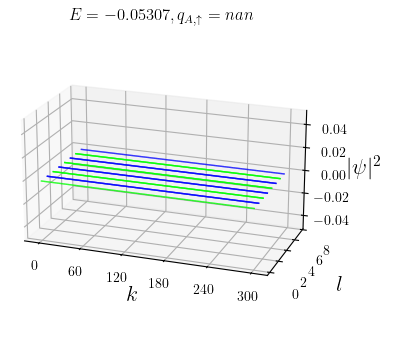

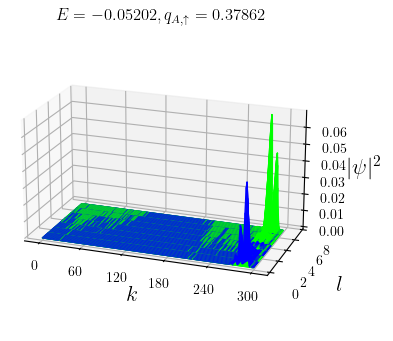

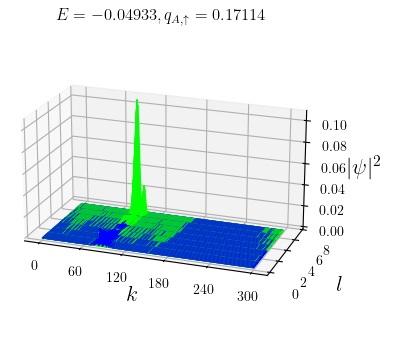

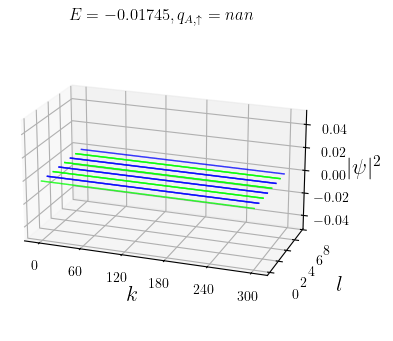

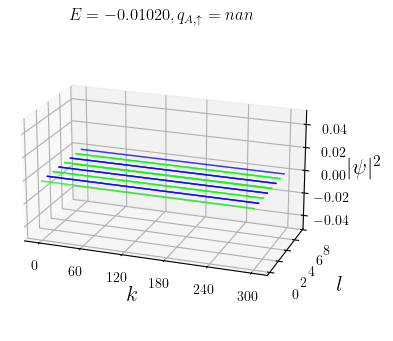

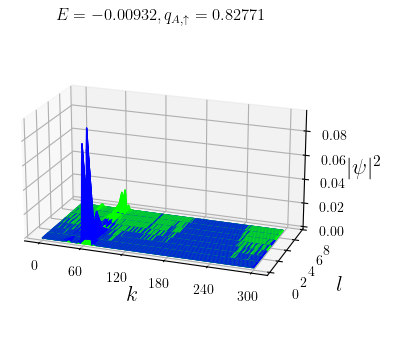

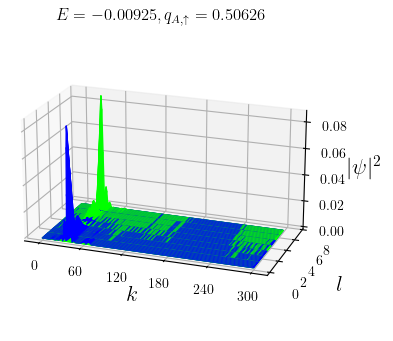

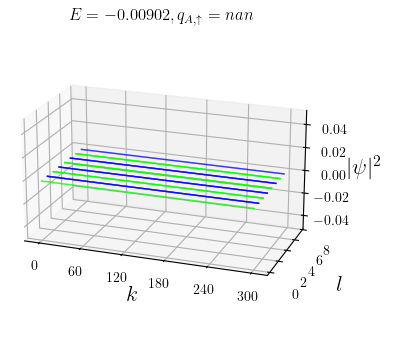

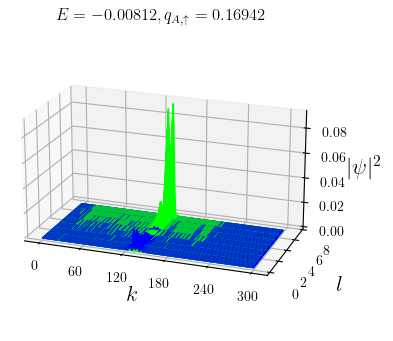

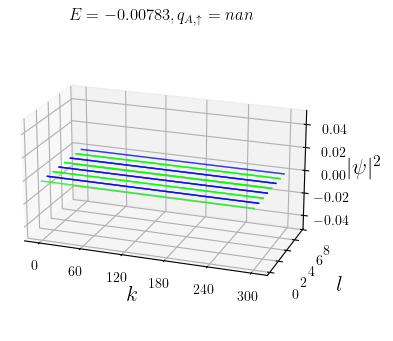

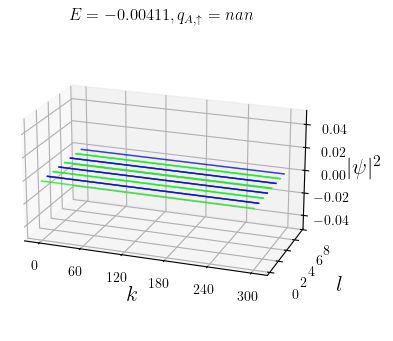

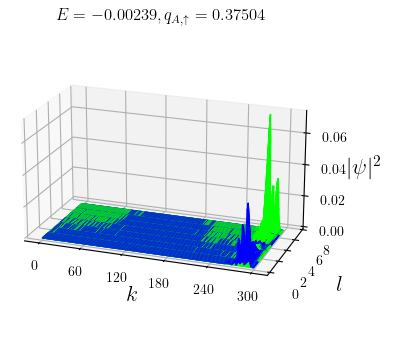

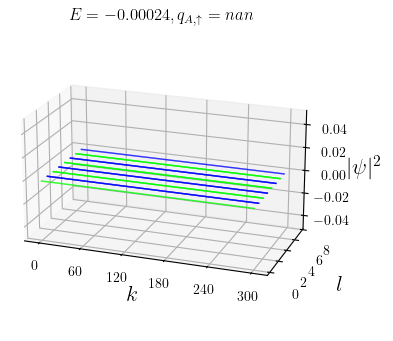

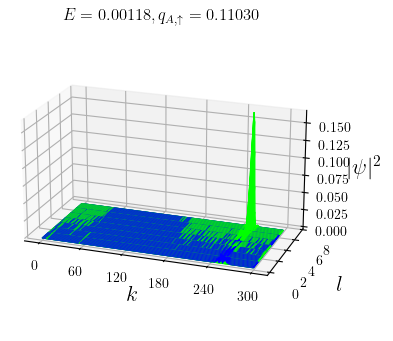

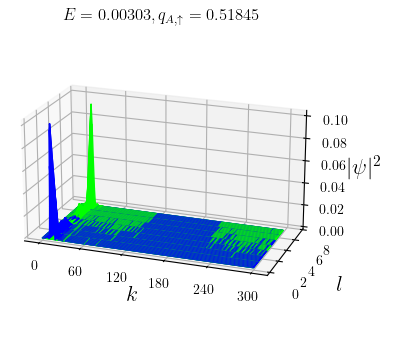

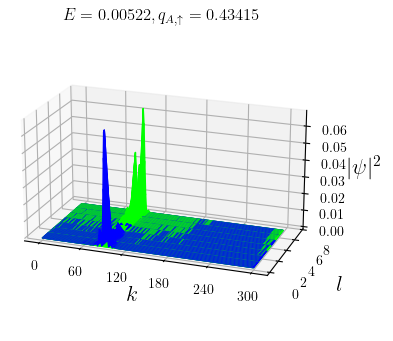

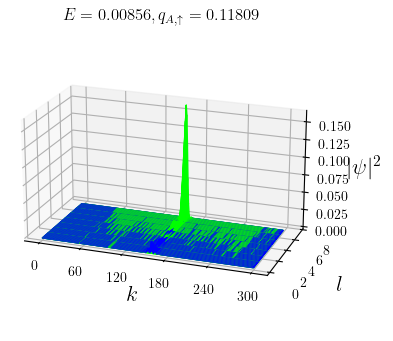

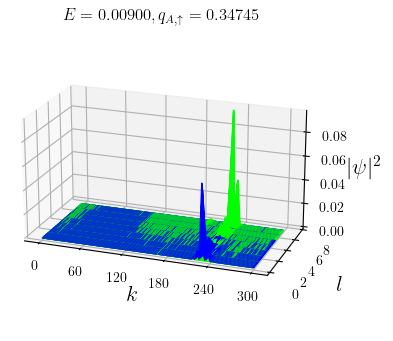

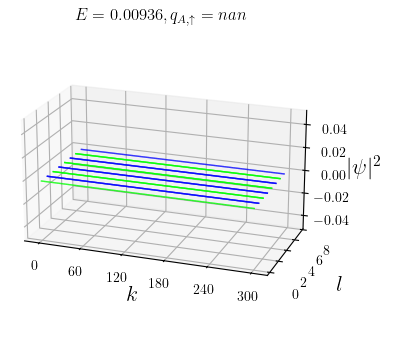

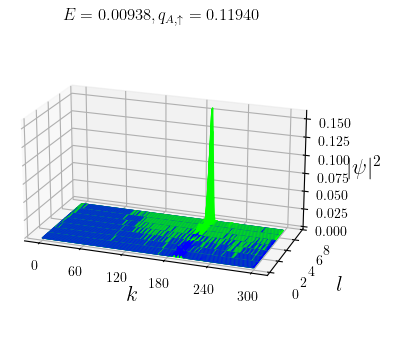

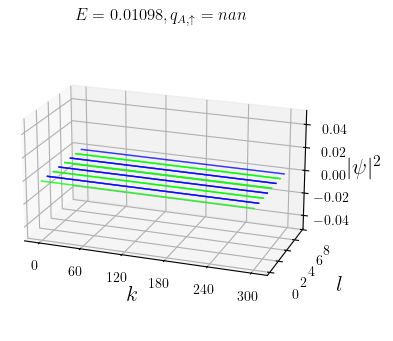

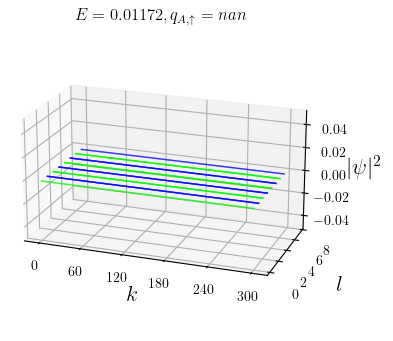

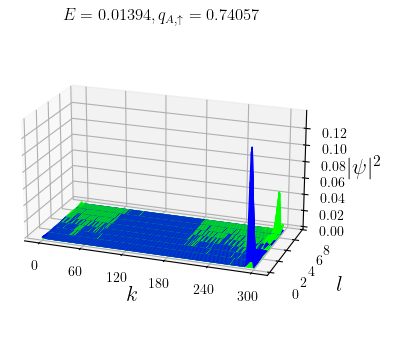

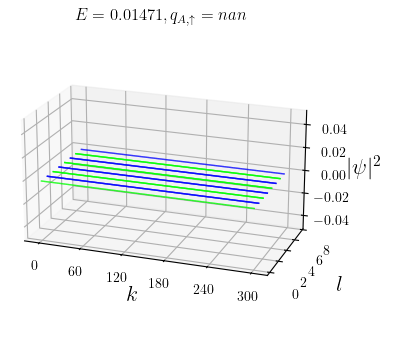

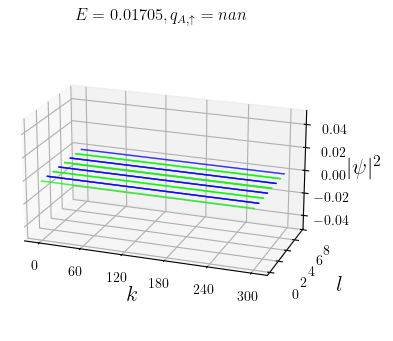

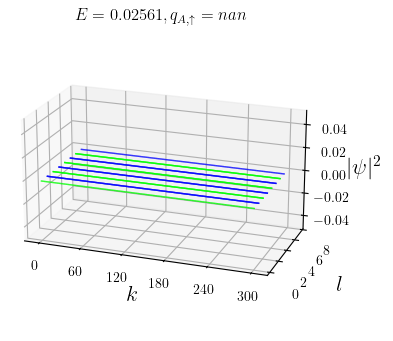

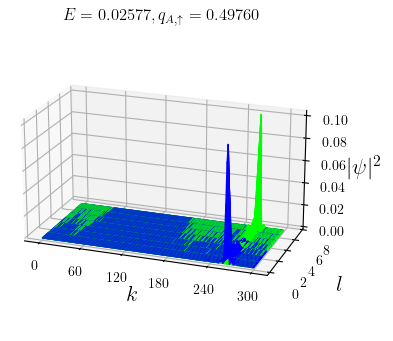

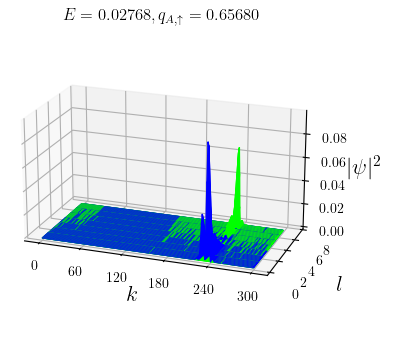

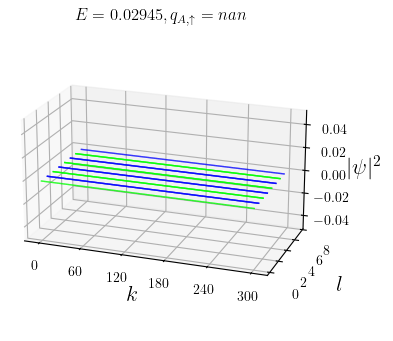

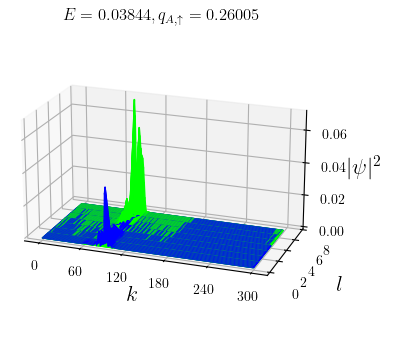

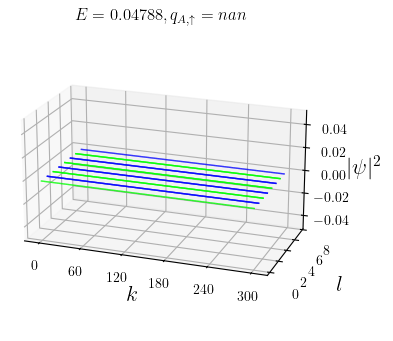

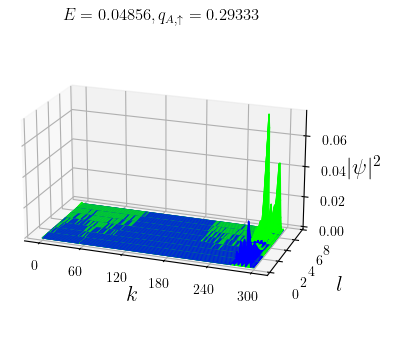

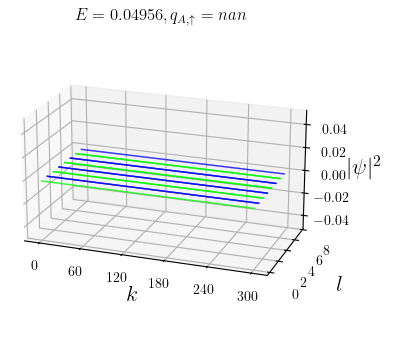

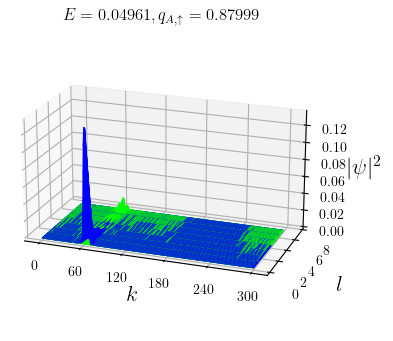

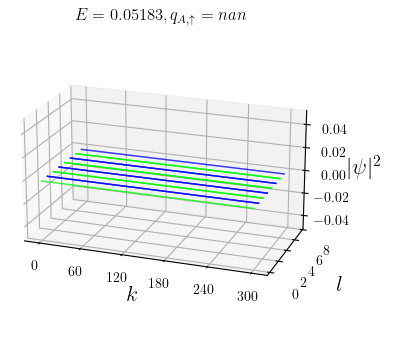

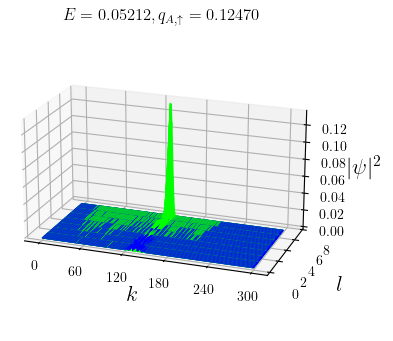

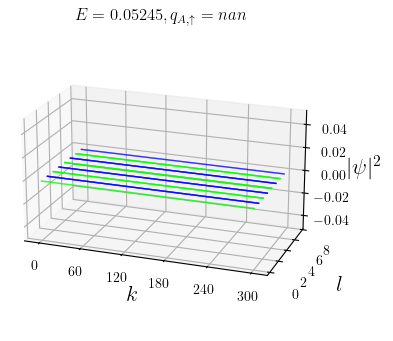

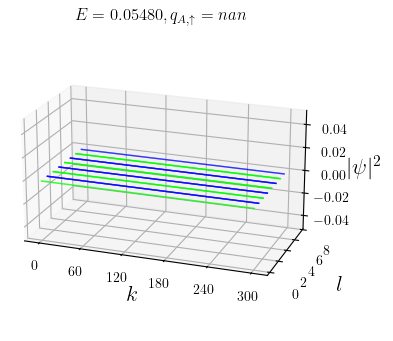

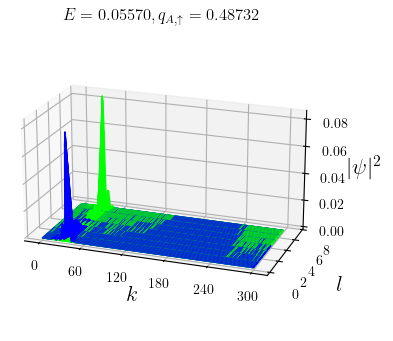

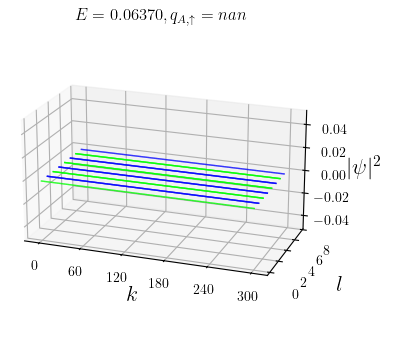

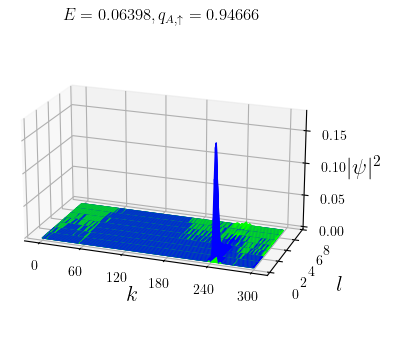

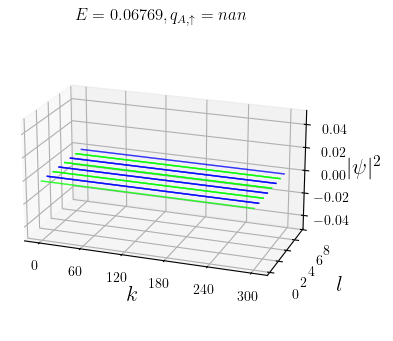

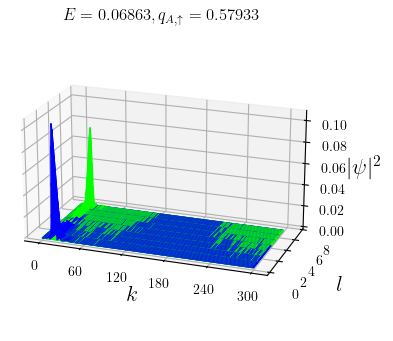

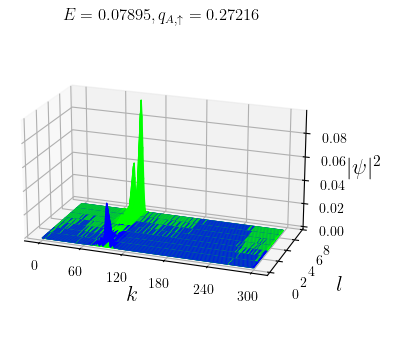

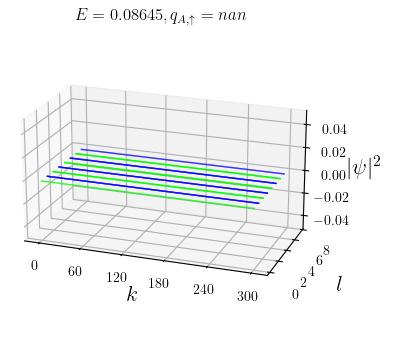

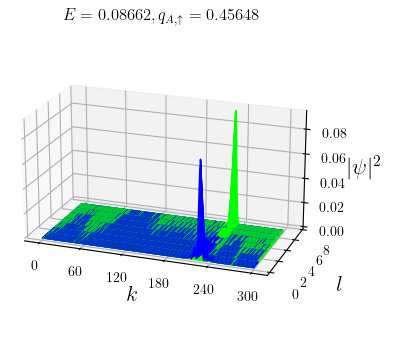

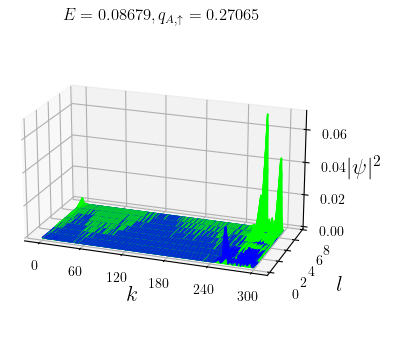

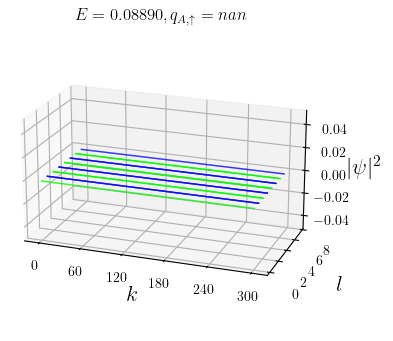

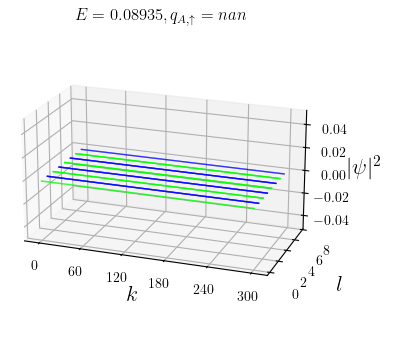

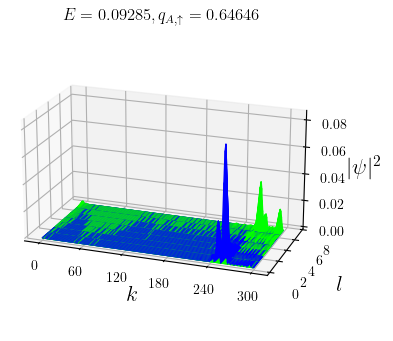

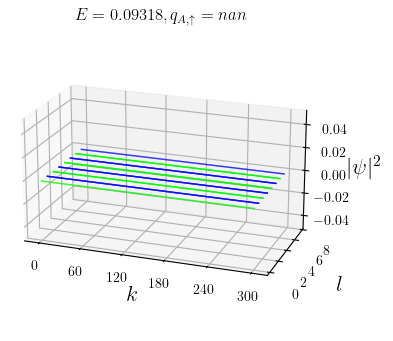

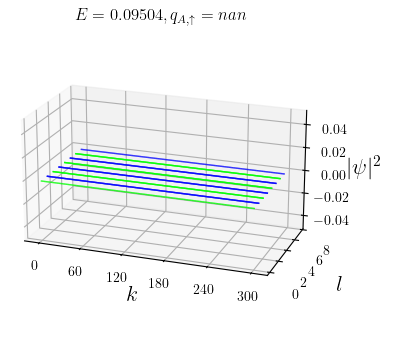

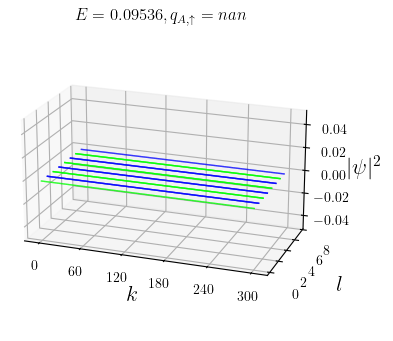

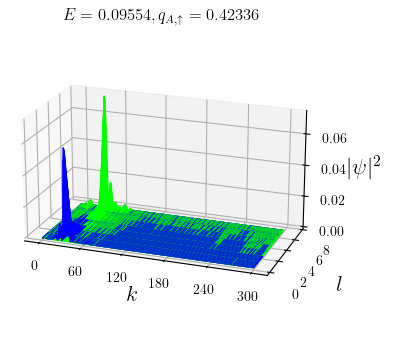

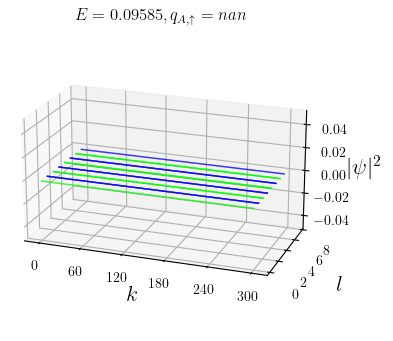

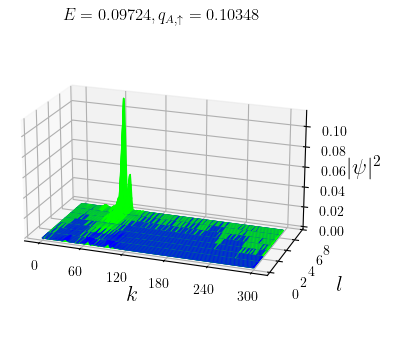

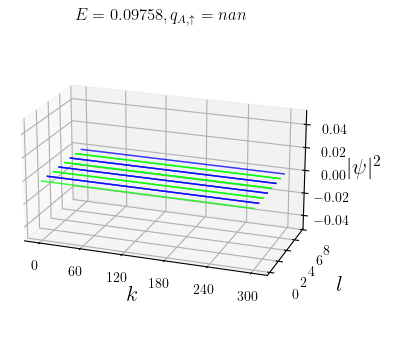

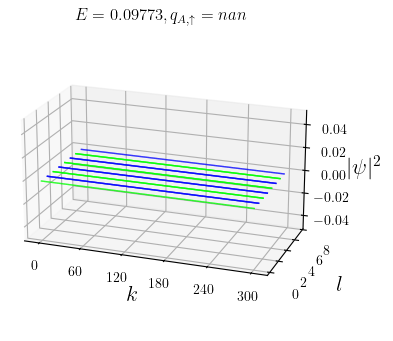

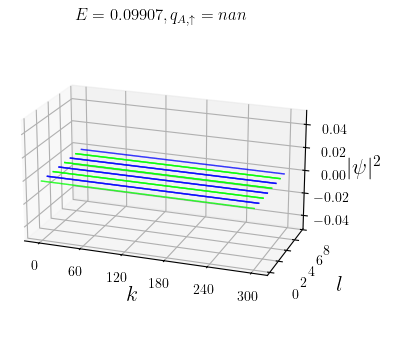

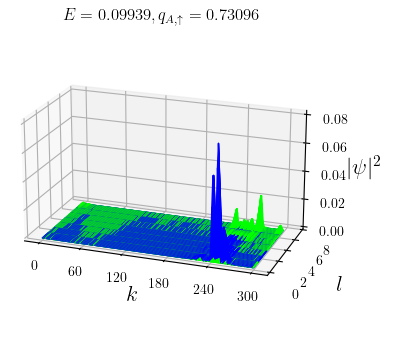

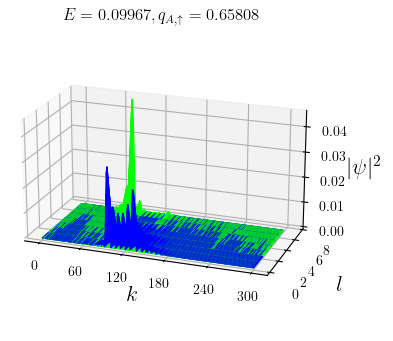

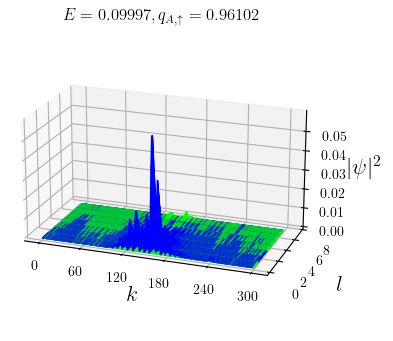

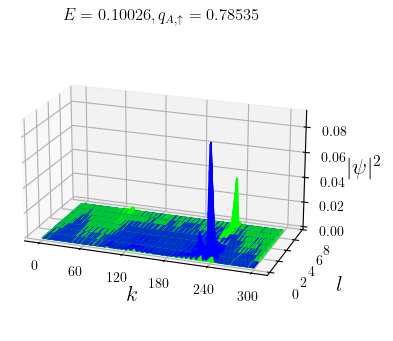

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

plt.rcParams.update({'text.usetex': True})

# fig = plt.figure(dpi=300)
# ax = fig.add_subplot(1,1,1, projection="3d")


listA = []
listB = []
list_overlap = []


for i in range(Lx * Ly):
    yi = Ly - (i // Lx + 1) + 1
    if yi % 2 == 0:
        listA.append(i)
    else:
        listB.append(i)

for i in range(Lx * Ly):
    yi = Ly - (i // Lx + 1) + 1
    if Ly/2 -1 <= yi <= Ly/2:
        list_overlap.append(i)



for ORDER_up in range(10, 90):
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1, projection="3d")
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    # ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_xlabel("$k$", fontsize=16)
    ax.set_ylabel("$l$", fontsize=16)
    ax.zaxis.set_rotate_label(False) 
    ax.set_zlabel("$| \psi |^2$", fontsize=16, rotation=0)
    ax.set_box_aspect((2,1,1))
    ax.grid([1])
    colors = [
        '#0504aa',  # blue royal
        '#01ff07',  # green light
    ]
    # Make data.
    X = np.arange(Lx)
    Y = np.arange(Ly)
    X, Y = np.meshgrid(X, Y)
    # For fractional charges, we plot A sites and B sites separately
    # where A and B sites differ in Ly
    ###########
    # ORDER_up = i
    density_up = prob_density(vec_up, ORDER_up, Lx, Ly)
    qa_up = np.sum(np.take(prob_density(vec_up, ORDER_up, Lx, Ly), listA))
    energy_up = val[ORDER_up]
    ###########
    prob_A_up = []
    prob_B_up = []
    for site_index, element in enumerate(density_up):
        yi = Ly - (site_index // Lx + 1) + 1
        if yi % 2 == 0:
            prob_A_up.append(0)
            prob_B_up.append(element)
        else:
            prob_A_up.append(element)
            prob_B_up.append(0)

    col1 = np.full(np.reshape(prob_A_up, (Ly, Lx)).shape, 'lime')
    col1[Ly-1, :] = np.full(Lx, 'none')
    col2 = np.full(np.reshape(prob_B_up, (Ly, Lx)).shape, 'blue')
    col2[Ly-1, :] = np.full(Lx, 'none')

    ax.plot_surface(np.append(X, X, axis=0),
                    np.append(Y, Y, axis=0),
                    np.append(np.reshape(prob_A_up, (Ly, Lx)), 
                            np.reshape(prob_B_up, (Ly, Lx)), axis=0),
                    facecolors= np.append(col1, col2, axis=0),
                    antialiased=True, edgecolors='k', linewidth=1, rstride=1, cstride=1,
                    zorder=1, shade=False)

    ax.set_xticks(np.arange(0, Lx+1, Lx//5))
    ax.set_yticks(np.arange(0, Ly+1, Ly//4))
    ax.view_init(elev=20., azim=-70)
    ax.set_title(r"$E = %1.5f, q_{A, \uparrow} = %1.5f $" 
                % tuple((energy_up, qa_up)))

    # plt.show()

/var/folders/8c/yvgv5fnx2nb77hcl4bw6dtzr0000gn/T/ipykernel_47960/133886839.py:4: RuntimeWarning: invalid value encountered in divide
  density = density/np.sum(density)
/var/folders/8c/yvgv5fnx2nb77hcl4bw6dtzr0000gn/T/ipykernel_47960/2189530900.py:76: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(np.append(X, X, axis=0),
/var/folders/8c/yvgv5fnx2nb77hcl4bw6dtzr0000gn/T/ipykernel_47960/2189530900.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(dpi=100)


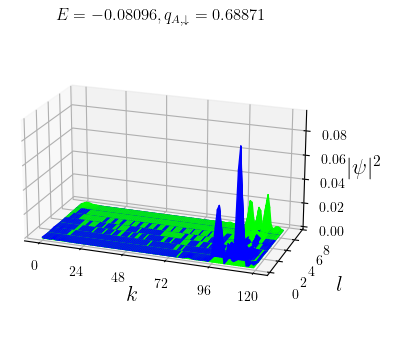

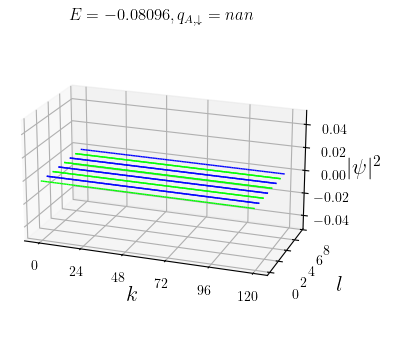

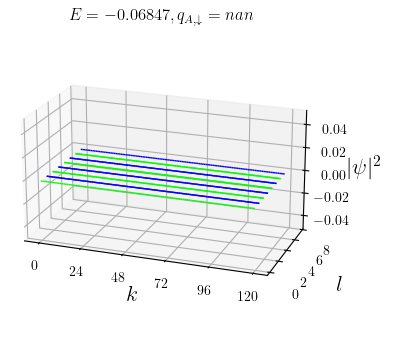

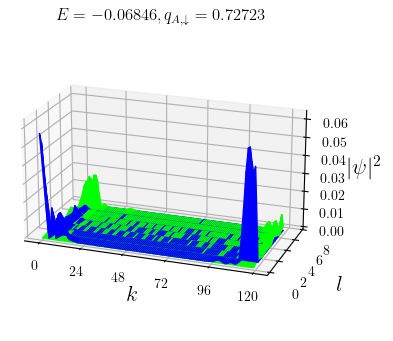

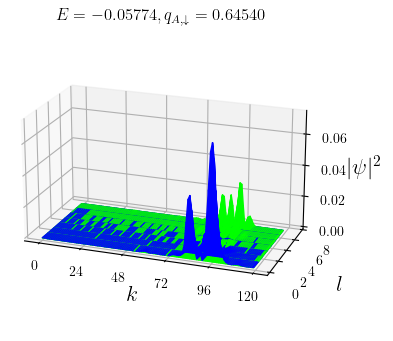

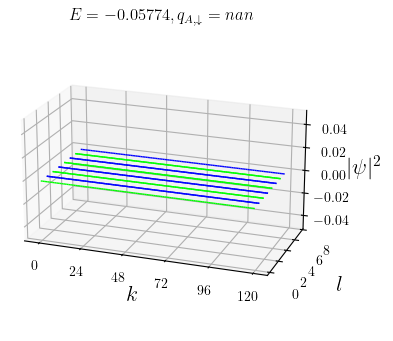

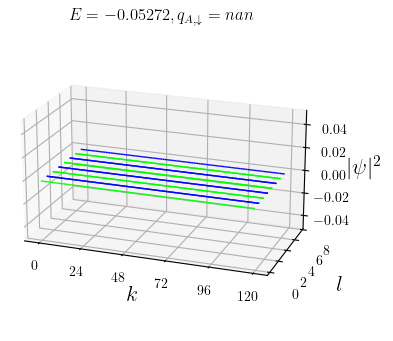

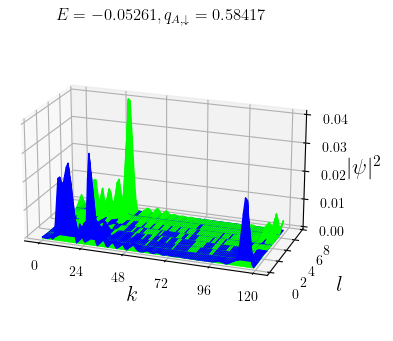

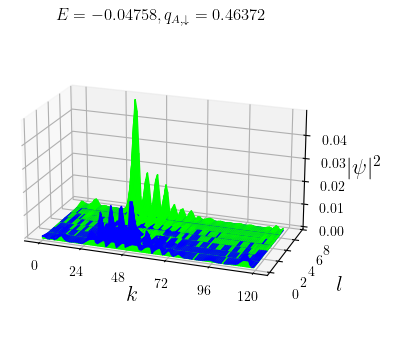

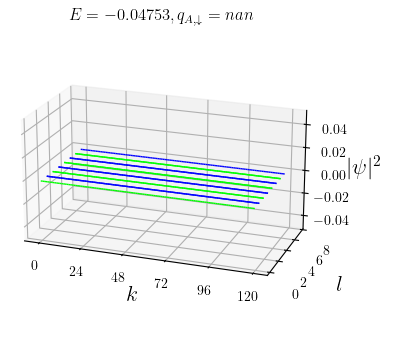

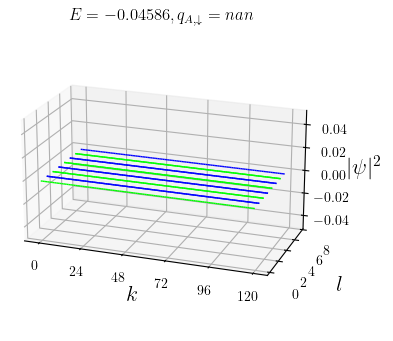

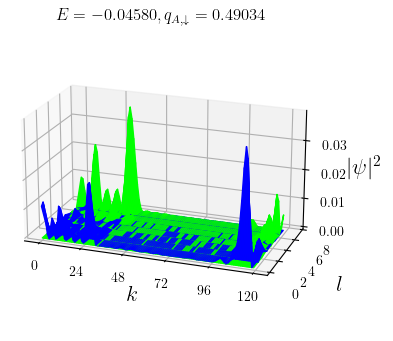

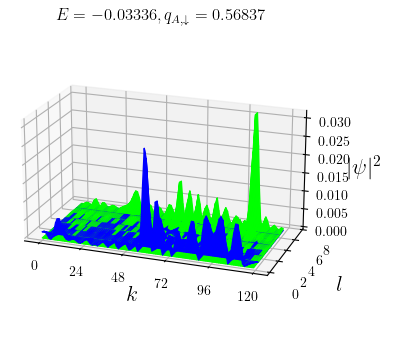

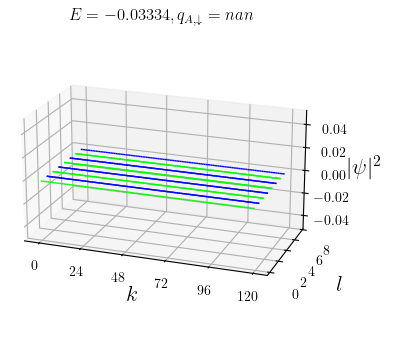

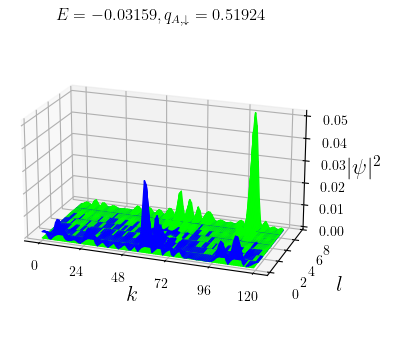

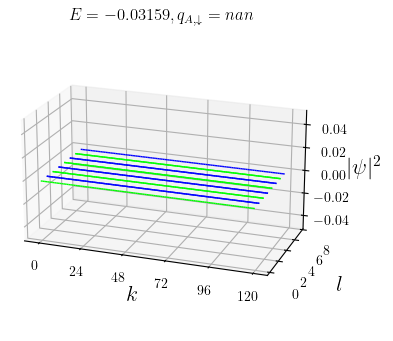

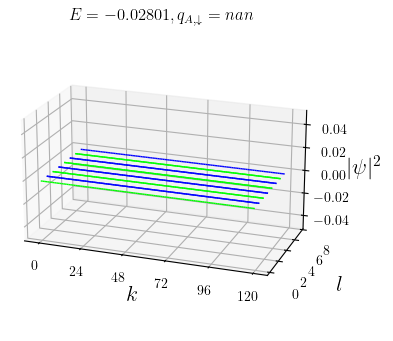

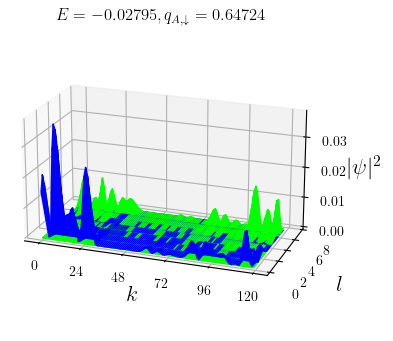

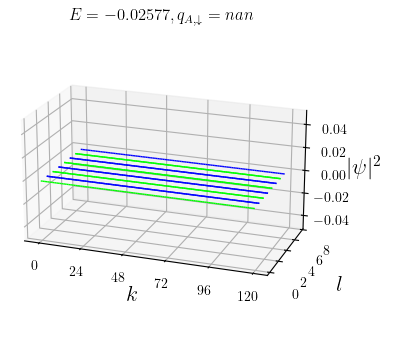

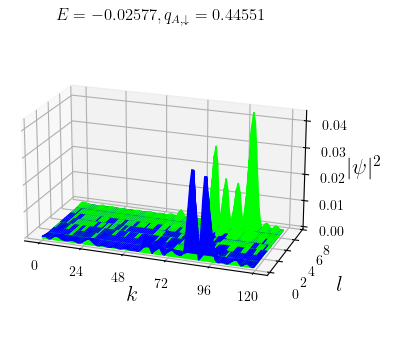

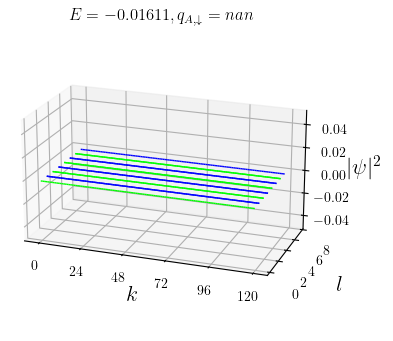

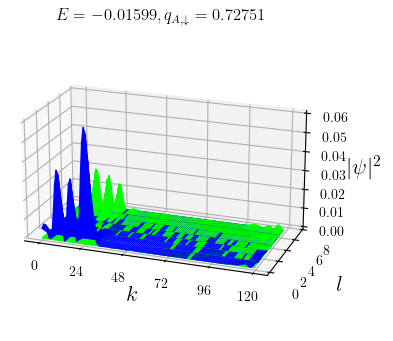

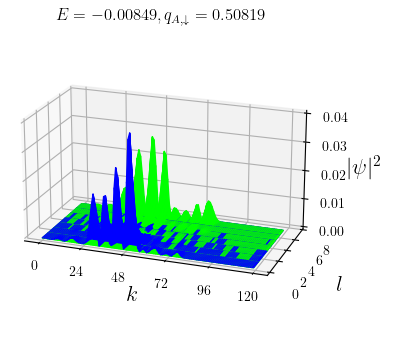

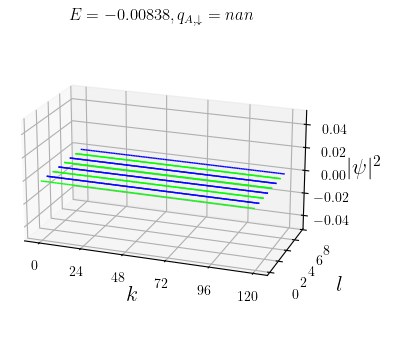

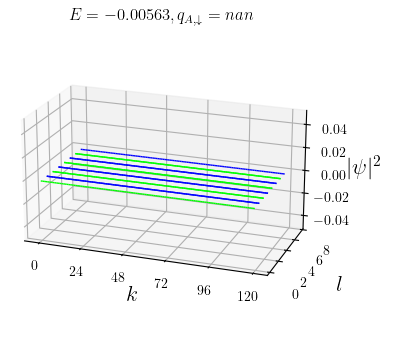

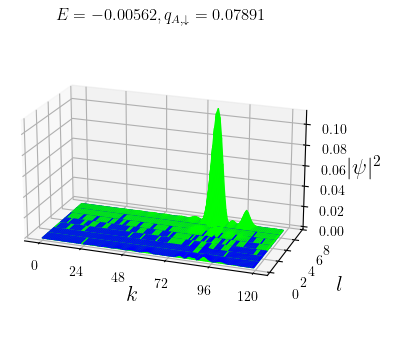

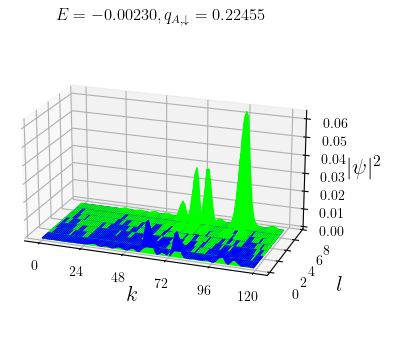

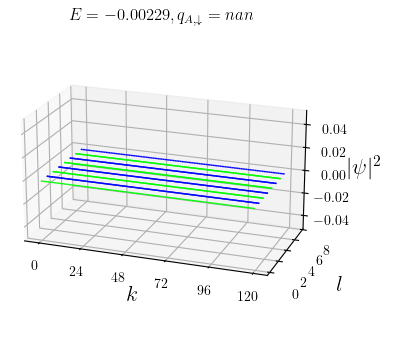

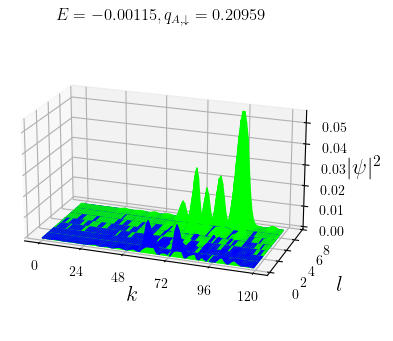

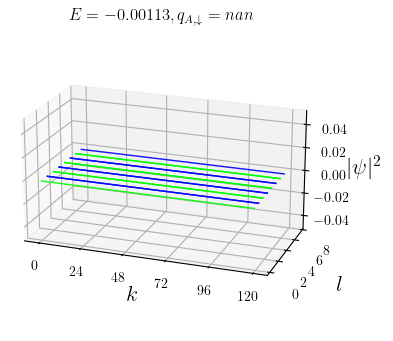

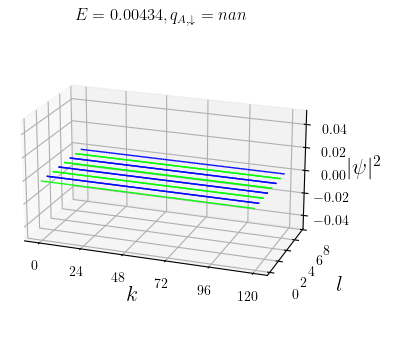

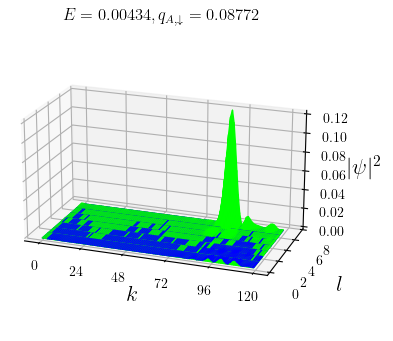

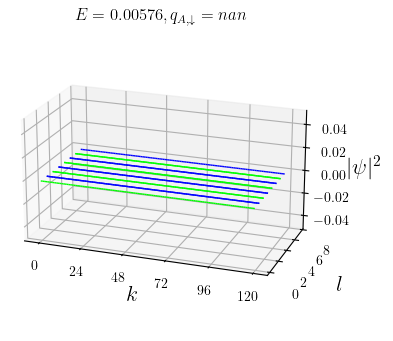

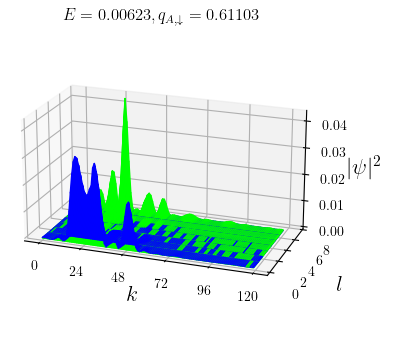

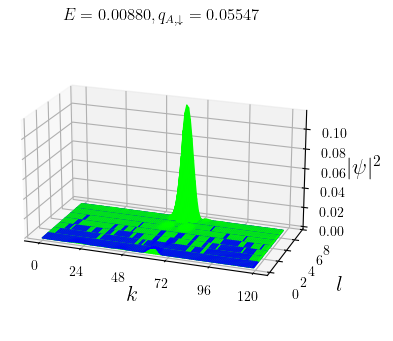

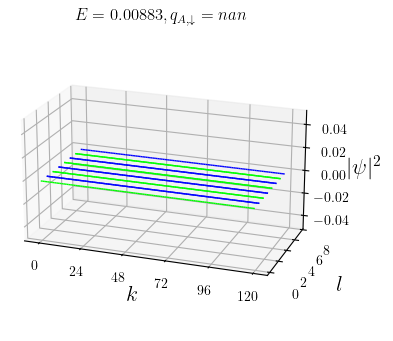

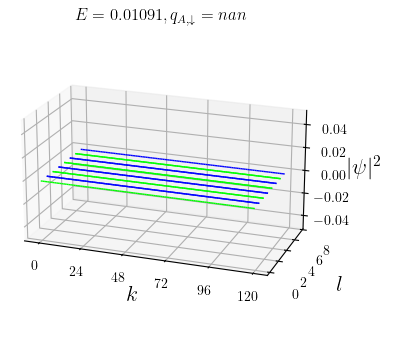

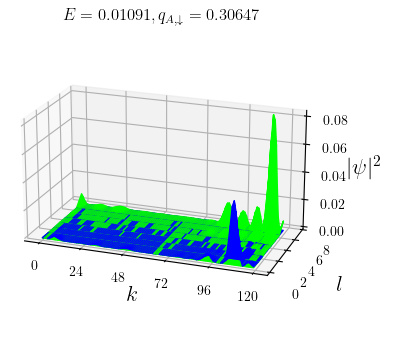

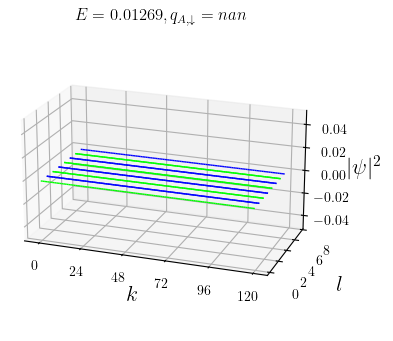

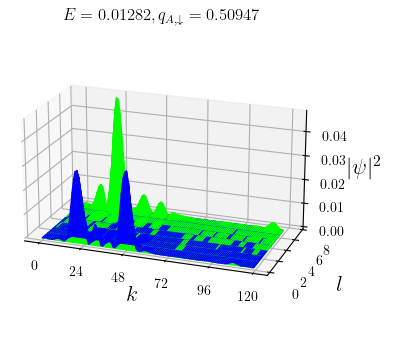

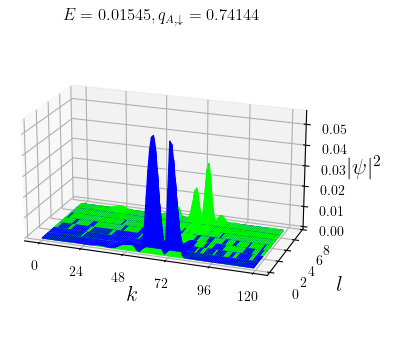

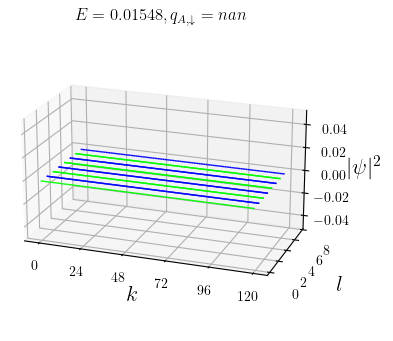

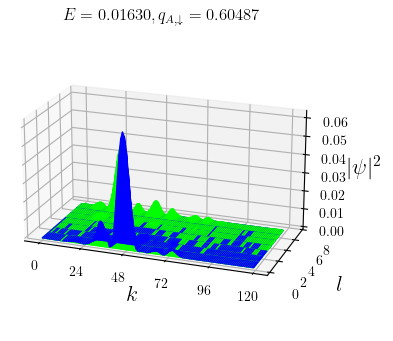

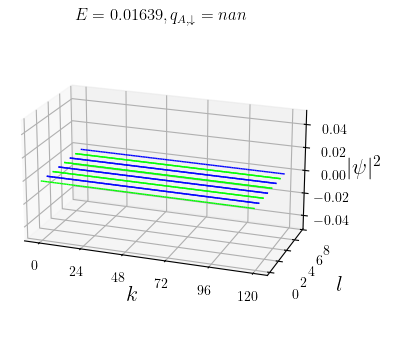

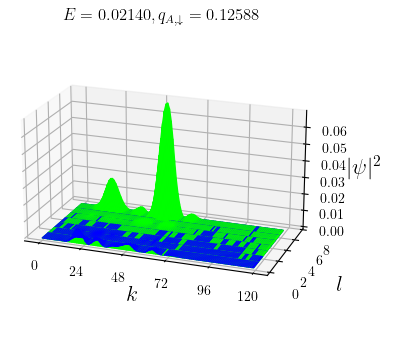

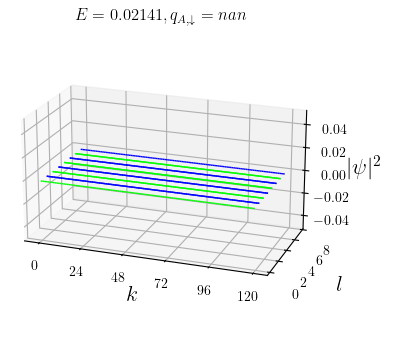

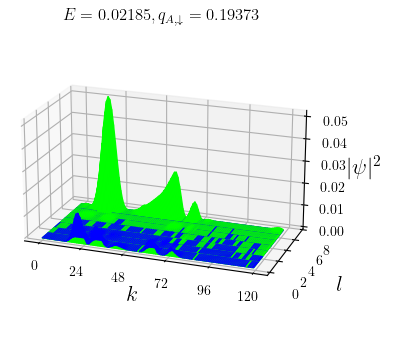

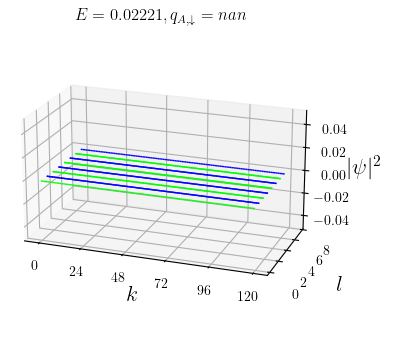

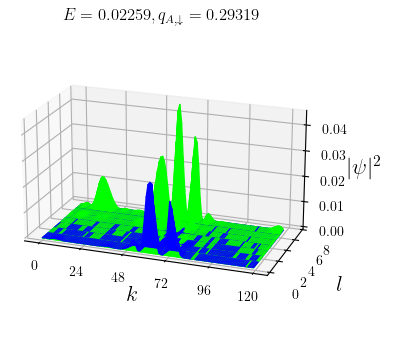

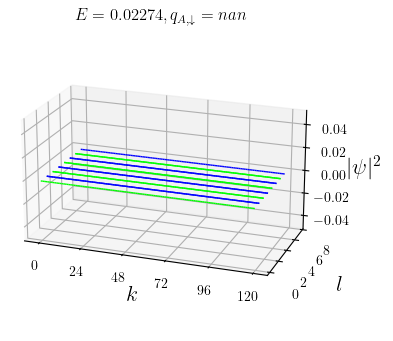

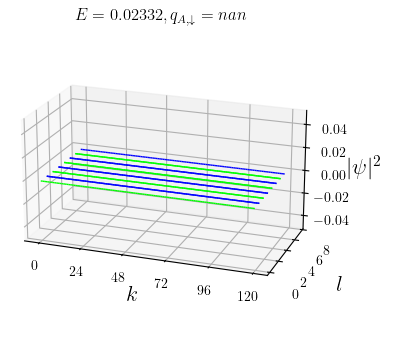

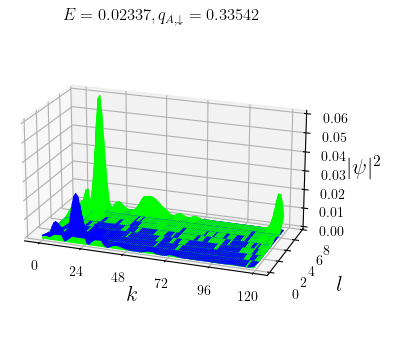

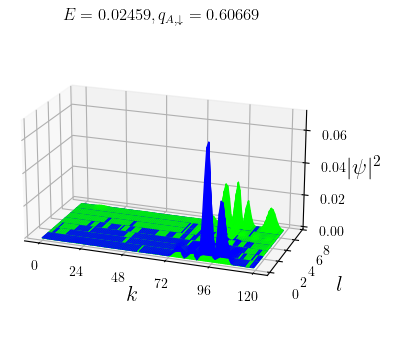

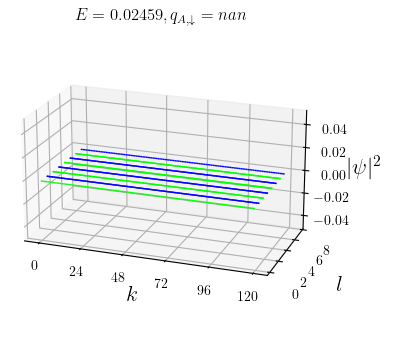

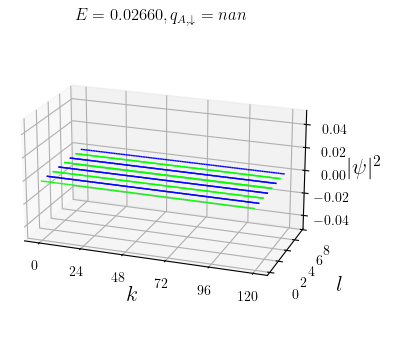

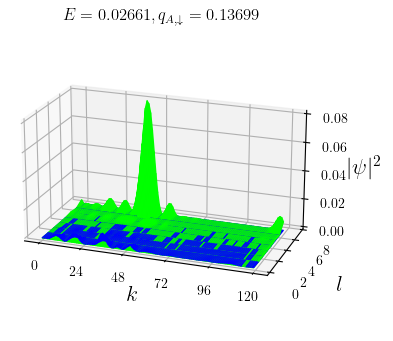

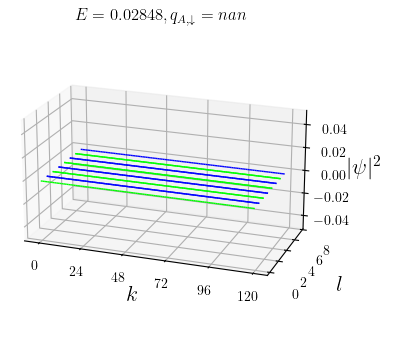

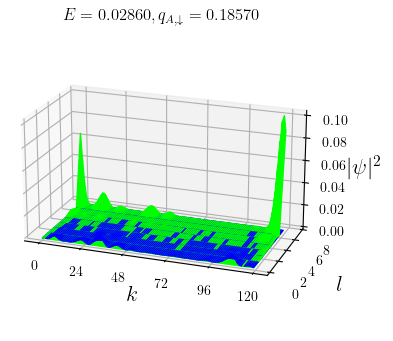

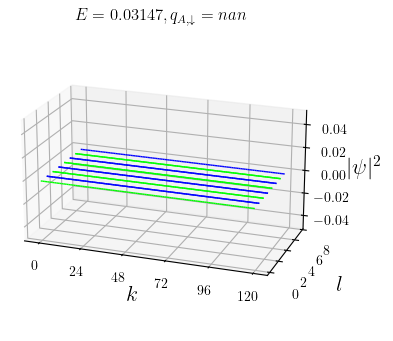

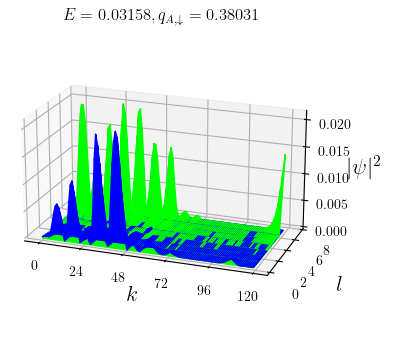

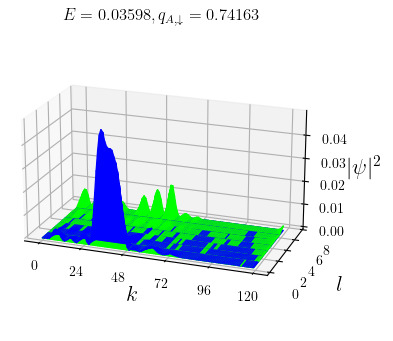

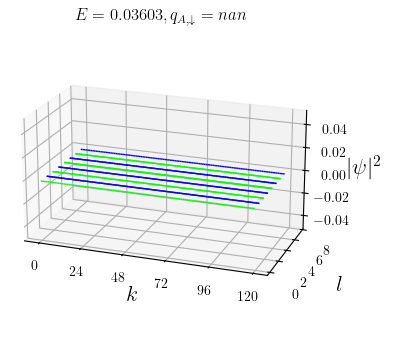

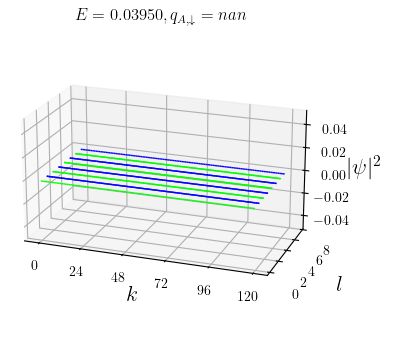

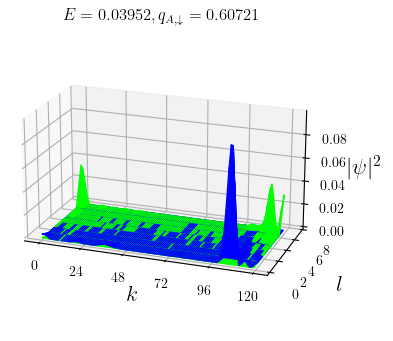

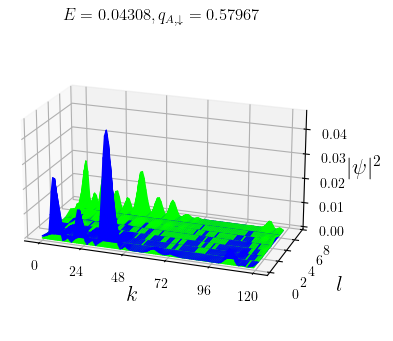

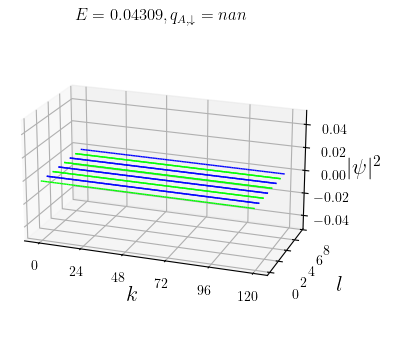

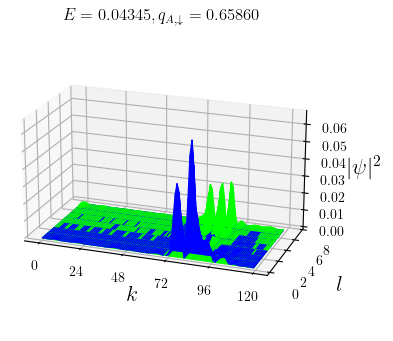

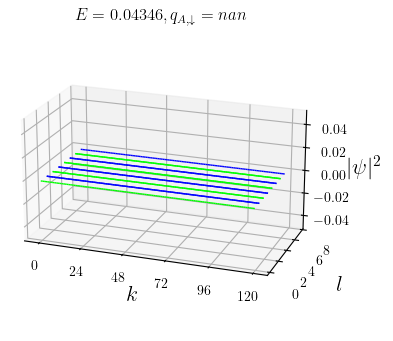

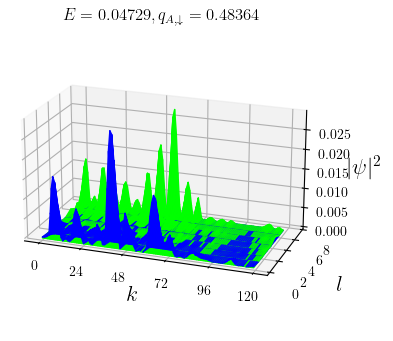

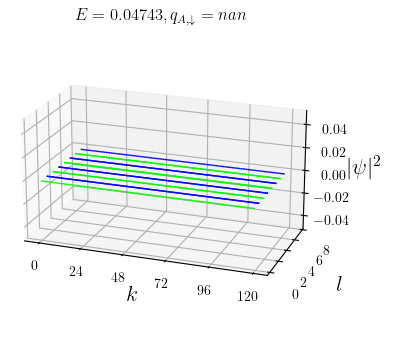

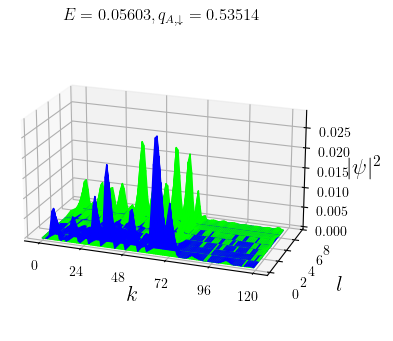

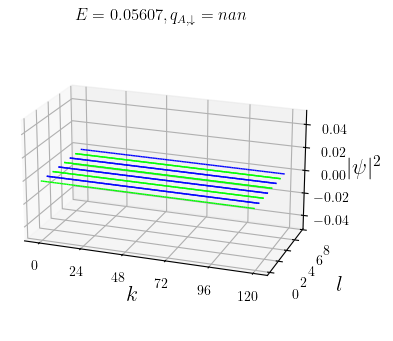

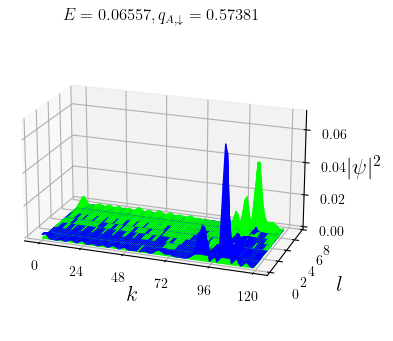

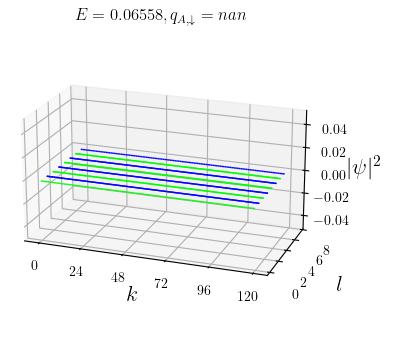

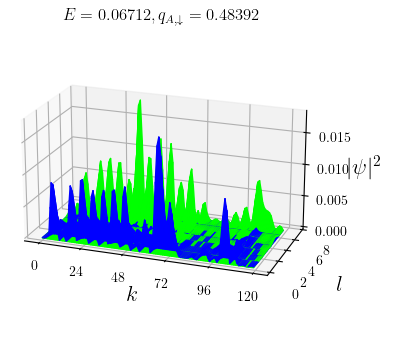

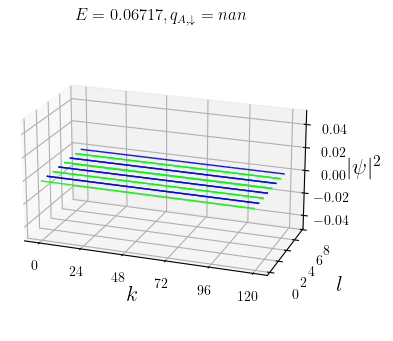

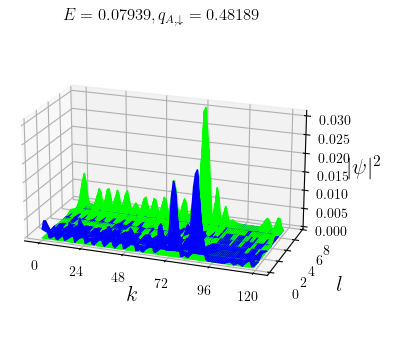

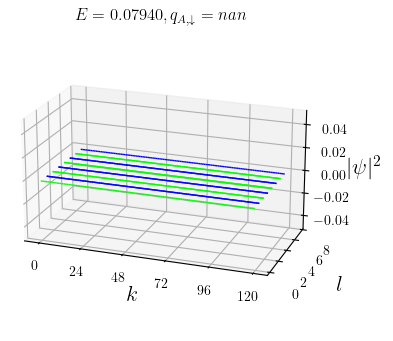

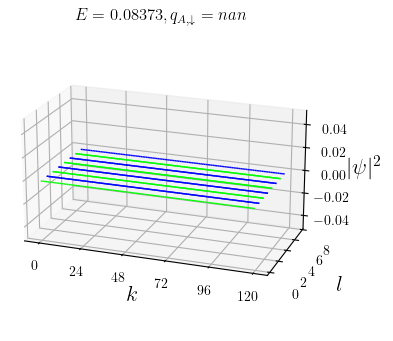

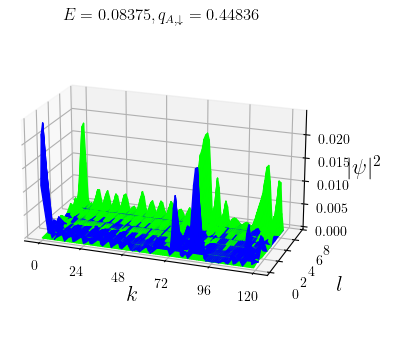

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

plt.rcParams.update({'text.usetex': True})

# fig = plt.figure(dpi=300)
# ax = fig.add_subplot(1,1,1, projection="3d")


listA = []
listB = []
list_overlap = []


for i in range(Lx * Ly):
    yi = Ly - (i // Lx + 1) + 1
    if yi % 2 == 0:
        listA.append(i)
    else:
        listB.append(i)

for i in range(Lx * Ly):
    yi = Ly - (i // Lx + 1) + 1
    if Ly/2 -1 <= yi <= Ly/2:
        list_overlap.append(i)



for ORDER_up in range(10, 90):
    fig = plt.figure(dpi=100)
    ax = fig.add_subplot(1,1,1, projection="3d")
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    # ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_xlabel("$k$", fontsize=16)
    ax.set_ylabel("$l$", fontsize=16)
    ax.zaxis.set_rotate_label(False) 
    ax.set_zlabel("$| \psi |^2$", fontsize=16, rotation=0)
    ax.set_box_aspect((2,1,1))
    ax.grid([1])
    colors = [
        '#0504aa',  # blue royal
        '#01ff07',  # green light
    ]
    # Make data.
    X = np.arange(Lx)
    Y = np.arange(Ly)
    X, Y = np.meshgrid(X, Y)
    # For fractional charges, we plot A sites and B sites separately
    # where A and B sites differ in Ly
    ###########
    # ORDER_up = i
    density_up = prob_density(vec_dn, ORDER_up, Lx, Ly)
    qa_dn = np.sum(np.take(prob_density(vec_dn, ORDER_up, Lx, Ly), listA))
    energy_dn = val[ORDER_up]
    ###########
    prob_A_dn = []
    prob_B_dn = []
    for site_index, element in enumerate(density_up):
        yi = Ly - (site_index // Lx + 1) + 1
        if yi % 2 == 0:
            prob_A_dn.append(0)
            prob_B_dn.append(element)
        else:
            prob_A_dn.append(element)
            prob_B_dn.append(0)

    col1 = np.full(np.reshape(prob_A_dn, (Ly, Lx)).shape, 'lime')
    col1[Ly-1, :] = np.full(Lx, 'none')
    col2 = np.full(np.reshape(prob_B_dn, (Ly, Lx)).shape, 'blue')
    col2[Ly-1, :] = np.full(Lx, 'none')

    ax.plot_surface(np.append(X, X, axis=0),
                    np.append(Y, Y, axis=0),
                    np.append(np.reshape(prob_A_dn, (Ly, Lx)), 
                            np.reshape(prob_B_dn, (Ly, Lx)), axis=0),
                    facecolors= np.append(col1, col2, axis=0),
                    antialiased=True, edgecolors='k', linewidth=1, rstride=1, cstride=1,
                    zorder=1, shade=False)

    ax.set_xticks(np.arange(0, Lx+1, Lx//5))
    ax.set_yticks(np.arange(0, Ly+1, Ly//4))
    ax.view_init(elev=20., azim=-70)
    ax.set_title(r"$E = %1.5f, q_{A, \downarrow} = %1.5f $" 
                % tuple((energy_dn, qa_dn)))

    # plt.show()